# Deep Learning - MNIST y predicción de números escritos a mano
## Julio Antonio Fresneda García

# Resumen:
**Vamos a intentar entrenar una red neuronal completa para el dataset MNIST, el cual se obtiene a través de la propia librería de Tensorflow y Keras. Buscaremos también el learning rate óptimo, e intentar superar el 98% de precisión.**


#### Condiciones adicionales
Para distinguir este ejercicio de otros ya resueltos en internet, añadiremos, además, algunas condiciones adicionales en este ejercicio:

   * Utilizar 3 y 4 capas ocultas
   * Por cada modelo, crear dos versiones con distinto número de neuronas en las capas ocultas
   * Para la mejor red neuronal de 3 capas y la mejor red neuronal de 4 capas, crear dos versiones alternativas con distinto learning rate.
   * Los comentarios tendrán especial peso en esta práctica.

# Planteamiento del ejercicio

Este ejercicio es un clásico a la hora de practicar con algoritmos de clasificación. El dataset MNIST representa miles de números del 0 al 9 escritos a mano alzada, los cuales nuestros modelos deberán clasificar correctamente. 
En este caso, usaremos redes neuronales profundas (DNN), en las cuales hay una capa de neuronas de input, otra de output, y entre ellas algunas capas ocultas. Al ser completas, cada una de las neuronas de una capa está conectada con todas las neuronas de la siguiente capa.

Si bien este ejercicio es a priori sencillo, tenemos muchas formas de "complicarlo", o hacerlo más interesante, por ejemplo, probando con distintos hiperparámetros.

Para esquematizar este trabajo, vamos a dividirlo en los siguientes puntos, los cuales se desarrollarán en profundidad a lo largo del notebook:

   * Carga, transformaciones y exploración del dataset
   * Hiperparámetros: Cuáles combinamos, cuáles cambiamos y cuáles dejamos por defecto
   * Declaración de funciones auxiliares
   * Entrenamiento de distintos modelos, comparativas y resultados
   * Conclusiones

# Carga, transformaciones y exploración del dataset
Vamos a comenzar cargando el dataset. Keras nos devuelve ya el dataset dividido en train y test.

In [1]:
import tensorflow as tf
tf.random.set_seed(0)
# Obtenemos MNIST
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
input_shape = X_train.shape
input_shape

2021-12-12 14:49:24.746011: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-12-12 14:49:24.746137: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


(60000, 28, 28)

Vemos que hay 60 mil entradas. En este dataset, cada número está codificado en forma de 28x28 píxeles. Cada píxel está representado por un número entre 0 y 255, donde 0 representa el color blanco, 255 el negro, y una escala de grises entre ambos.
Para entrenar, viene mejor que estos valores estén entre 0 y 1, por tanto vamos a escalar el dataset.

Nota: Los warning mostrados no son motivo de preocupación. El hardware en el que se ejecuta este notebook no usará la GPU para entrenar, ya que no tiene GPU dedicada. Es por ello que nos lo muestra como warning.

In [2]:
X_train = X_train / 255.0
X_test = X_test / 255.0

Tenemos el dataset ya separado en train y test. El test lo dejaremos apartado para probar nuestros modelos, y el train lo usaremos para entrenarlo.

Antes de nada, debemos plantearnos si vamos a volver a dividir el set de entrenamiento. Para evitar elegir modelos con bias u overfitting, a la hora de elegir modelo conviene usar algunas técnicas:

**¿Usamos K-fold Cross Validation?**
Si bien lo ideal puede ser seguir esta metodología, hay que tener en cuenta que el entrenamiento de redes neuronales es pesado en cuanto a computación, y el cross validation multiplicaría el número de veces que entrenamos todos los modelos.

Como tenemos un dataset relativamente grande, podemos permitirnos la licencia de **no** usar Cross Validation, y simplemente separar en set de entrenamiento y set de validación. Por tanto estamos en un punto intermedio entre usar CV y entrenar directamente con todo el set de entrenamiento con los riesgos que conlleva.

In [3]:
# Dividimos en train y valid (validacion)
X_valid = X_train[:4000]
X_train = X_train[4000:]

y_valid = y_train[:4000]
y_train = y_train[4000:]

Vamos a visualizar algunos números del dataset. Para ello, definimos una función auxiliar.

In [4]:
import matplotlib.pyplot as plt

# Pinta algunos ejemplos
def printSamples(X, y, n: int):
    nrows = int(n/10)
    ncols = 10
    plt.figure(figsize=(ncols * 1.2, nrows * 1.2))
    for row in range(nrows):
        for col in range(ncols):
            index = ncols * row + col
            plt.subplot(nrows, ncols, index + 1)
            plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
            plt.title(y_train[index], fontsize=10)
            plt.axis('off')
    plt.show()

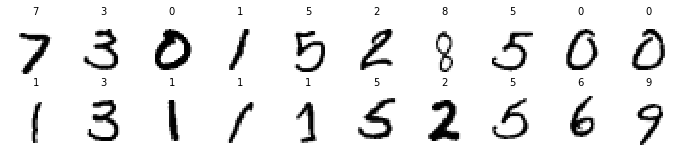

In [5]:
printSamples(X_train, y_train, 20)

Ya vemos que el dataset se ha cargado correctamente, y que tenemos algunos números que están evidentemente escritos a mano.

# Hiperparámetros: Cuáles combinamos, cuáles cambiamos y cuáles dejamos por defecto

Quizás, este es en mi opinión el paso más importante en este trabajo. La cantidad de hiperparámetros por elegir y tunear en redes neuronales es abrumadora, y muchos muy importantes a la hora de obtener un buen modelo.

**¿Cómo encontramos los valores óptimos?**
Hay una solución óptima: Probarlos todos, y todas las conbinaciones posibles. Si bien esto es computacionalmente inasumible, debemos priorizar. Por ello, habrá que elegir qué hiperparámetros combinar (dando lugar a varios modelos), qué hiperparámetros cambiar, y qué hiperparámetros dejar por defecto.

Desde el enunciado ya nos obligan a combinar algunos hiperparámetros:

   * Número de capas ocultas: 3 y 4
   * Número de neuronas en estas capas ocultas: Dos versiones, número concreto a elegir por el alumno
   * Learning rate: Dos versiones para el mejor de 3 capas y mejor de 4 capas, learning rate óptimo y otro con un valor alternativo
   
Teniendo en cuenta lo anterior, como mínimo tendremos que entrenar 2x2x2 = 8 modelos. Dado que tenemos tiempo para entrenar algunos más, vamos a hacer algunas combinaciones adicionales con otros hiperparámetros. 

Para tener una idea de la cantidad de hiperparámetros que podemos elegir cambiar, vamos a ver una lista con algunos de los más importantes:

   * **Learning rate constante: Valor**
   * **Learning rate no constante: Learning Rate Schredulers**
   * **Optimizador**
   * Batch size
   * Función de activación
   * *Número de epochs*
   * **Número de capas ocultas**
   * **Número de neuronas por capa oculta**
   * Lógica de inicialización de pesos
   * *Usar o no Early Stopping*
   
Se han señalado en **negrita** los hiperparámetros que vamos a combinar (vamos a probar con varios). 
También se han señalado en *cursiva* los hiperparámetros que vamos a elegir y que no van a cambiar, van a ser constantes para todos los modelos. 
El resto de hiperparámetros se quedarán por defecto.

Tantas combinaciones darán lugar a muchos modelos, y puede ser algo abrumador y dar lugar a confusión a la hora de seguir el desarrollo. Por tanto, vamos a seguir la siguiente estructura:

   * Cuatro modelos genéricos:
       * NN con 3 capas ocultas y 40, 30 y 20 neuronas, respectivamente y por cada capa.
       * NN con 4 capas ocultas, y 50, 40, 30 y 20 neuronas, respectivamente y por cada capa.
       * NN con 3 capas ocultas y 400, 300 y 200 neuronas, respectivamente y por cada capa.
       * NN con 4 capas ocultas, y 500, 400, 300 y 200 neuronas, respectivamente y por cada capa.
   * Para cada uno de estos modelos:
       * Probar con cuatro optimizadores distintos: SGD, Adam, RMSprop, Adadelta.
       * A su vez, por cada optimizador, probar con un learning rate constante (óptimo), y tres funciones personalizadas adicionales
       
Por tanto, entrenaremos 4x4x4 = 64 modelos totales. Tampoco usaremos Early Stopping, por tanto este entrenamiento va a ser computacionalmente potente, pero asumible.

Con estas combinaciones, cumplimos con los puntos pedidos en el enunciado y por el profesor, ya que el conjunto de modelos pedidos es un subconjunto del conjunto de 64 modelos que tendremos.

El número de epochs será de 20.

**Nota: Si bien es cierto que en la guía se recomienda usar early stopping, personalmente he decidido no hacerlo. Por varias razones:**

   * Me parece interesante ver cómo en algunos casos se llega al overfitting, como así se ve en algunas gráficas
   * Sin early stopping, podemos intuir con qué hiperparámetros podemos reducir este riesgo de overfitting
   * Si bien el entrenamiento es mucho más lento, personalmente no me importa esperar

## Hiperparámetros: Learning rate
Las DNN son entrenadas usando algoritmos de optimización basadas en el gradiente descendiente escolástico (SGD). 
La tasa de aprendizaje o learning rate, es un hiperparámetro que controla cuanto cambia el modelo a respuesta del error estimado cada vez que los pesos del modelo se actualizan. 

Elegir un learning rate muy grande resultará en un entrenamiento rápido, pero dificultad para converger en un óptimo. En cambio, un learning rate muy pequeño dará lugar a un entrenamiento mucho más lento, además de la posibilidad de quedarnos atascados en sub-óptimos, sin "fuerza" para salir de él.

Es por eso, que elegir un learning rate óptimo (ni muy grande, ni muy pequeño), es importante.


### Encontrar el learning rate óptimo
Una buena forma, puede ser entrenar el modelo comenzando con un learning rate muy pequeño y haciéndolo más grande conforme avanza el entrenamiento. Si pintamos un gráfico donde el eje vertical represente las pérdidas, y el eje horizontal represente el learning rate, veremos cómo las pérdidas van descendiendo, hasta que llega un tramo donde se vuelven inestables y justo después ascienden radicalmente. El learning rate óptimo será en ese punto donde no llega a la inestabilidad.

Para pintar este gráfico, podemos usar la siguiente clase, la cual usaremos más adelante.(*https://sachinruk.github.io/blog/tensorflow/learning%20rate/2021/02/15/Tensorflow-Learning-Rate-Finder.html*)

In [6]:
# https://sachinruk.github.io/blog/tensorflow/learning%20rate/2021/02/15/Tensorflow-Learning-Rate-Finder.html
class LRFind(tf.keras.callbacks.Callback): 
    def __init__(self, min_lr, max_lr, n_rounds): 
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.step_up = (max_lr / min_lr) ** (1 / n_rounds)
        self.lrs = []
        self.losses = []
     
    def on_train_begin(self, logs=None):
        self.weights = self.model.get_weights()
        self.model.optimizer.lr = self.min_lr

    def on_train_batch_end(self, batch, logs=None):
        self.lrs.append(self.model.optimizer.lr.numpy())
        self.losses.append(logs["loss"])
        self.model.optimizer.lr = self.model.optimizer.lr * self.step_up
        if self.model.optimizer.lr > self.max_lr:
            self.model.stop_training = True
        
    def on_train_end(self, logs=None):
        self.model.set_weights(self.weights)

### Learning rate descendiente: Scheduling
Si bien un learning rate constante puede ser a veces suficiente, podemos plantear alternativas. Idealmente, conforme avanza el entrenamiento, nos vamos acercando al óptimo, por lo que convendría que el SGD tomase pasos cada vez más pequeños. Usar un learning rate descendiente puede darnos mejores resultados.

Esto es lo que se conoce como Learning Rate Schedulers. Vamos a declarar tres funciones:

   * Polynomical Decay: El learning rate cae siguiendo una función polinómica
   * Exponential Decay: El learning rate cae de forma exponencial
   * Cyclical Decay: El learning rate se va decrementando e incrementando de forma cíclica

In [7]:
# Constant (Default)
#...

# Polynomical
starter_learning_rate = 0.25
end_learning_rate = 0.001
decay_steps = 10000
polynomical_LR_fn = tf.keras.optimizers.schedules.PolynomialDecay(
    starter_learning_rate,
    decay_steps,
    end_learning_rate,
    power=0.5)

# Exponential
initial_learning_rate = 0.25
exponential_LR_fn = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True)

# Cyclical
from tensorflow_addons.optimizers import CyclicalLearningRate
cyclical_LR_fn = CyclicalLearningRate(
 initial_learning_rate=0.1,
 maximal_learning_rate=0.1,
 step_size=1000,
 scale_fn=lambda x: 1 / (1.1 ** (x - 1)),
 scale_mode='cycle')

LR_schedules = [None, polynomical_LR_fn, exponential_LR_fn, cyclical_LR_fn]
LR_names = ['Constant_LR', 'Polynomical_Decay_LR', 'Exponential_Decay_LR', 'Cyclical_Decay_LR']

## Hiperparámetros: Optimizadores
Los optimizadores son algoritmos que buscan minimizar una función de error.
Los optimizadores que vamos a probar son los siguientes:

   * Stochastic Gradient Descent (SGD): Variante del gradiente descendiente, el cual actualiza los parámetros del modelo uno a uno. Como ventajas, los parámetros se actualizan frecuentemente y se necesita poca memoria. Como desventajas, tiene alta varianza y es computancionalmente expensivo.
   * Adaptive Moment Estimation (Adam): Basado en el gradiente descendiente. Computa learning rates adaptativos para cada parámetro. Es computacionalmente eficiente y no requiere mucha memoria.
   * Root Mean Square Propagation (RMS-Prop): Versión de Adagrad donde el learning rate es una media exponencial de gradientes. Como ventaja, el learning rate se ajusta automáticamente. Como desventaja, el aprendizaje es muy lento.
   * AdaDelta: Extension de Adagrad donde se reduce monotonicamente el learning rate. Como desventaja, es computacionalmente expensivo.
   
Como ya detallamos, vamos a probar todas las combinaciones de optimizadores y funciones de schedulers de learning rate. Es muy probable que algunas combinaciones no sean adecuadas e incluso no tengan sentido, veremos si funcionan a la hora de probarlas.

Estos optimizadores los obtendremos más adelante de la librería de tf.keras.

# Declaración de funciones auxiliares
Antes de comenzar a entrenar, vamos a declarar algunas funciones auxiliares.


## Funciones auxiliares de dibujado de gráficas

### plotModel
Dibuja estadísticas relacionadas con la clasificación, así como una matriz de confusión

In [8]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
import pandas as pd

def plotModel(model, name, X, y):
    
    # Predecimos usando el modelo
    ypred = model.predict(X)
 
    # Imprimimos el reporte de clasificación
    print(name + ": Classification report\n")
    print(classification_report(y, np.argmax(ypred,axis=1), target_names=['0','1','2','3','4','5','6','7','8','9']))

    # Dibujamos la matriz de confusión
    cm = confusion_matrix(y, np.argmax(ypred,axis=1))
    cm = pd.DataFrame(cm, range(10),range(10))
    plt.figure(figsize = (10,7))

    sns.heatmap(cm, annot=True, annot_kws={"size": 12}, fmt='g') # font size
    print(name + ": Confusion Matrix\n")
    plt.title(name + ": Confusion Matrix")
    plt.show()
    
    


### plotHistories
Dibuja subplots, un subplot por categoría. Dentro de cada categoría, pinta las historias (históricos del entrenamiento de los modelos) de cada modelo perteneciente a esa categoría. 

In [9]:
def plotHistories(histories, history_names, category_names, subplot_names, epochs = 20):
    
    # Dict de categorias
    categories = {}
    for cn in category_names:
        categories[cn] = []

    # Para cada histórico-nombre del histórico      
    for hist, hn in zip(histories, history_names):
        # Por cada categoria
        for cat in categories.keys():
            # Si un historico pertenece a la categoria (la contiene en el nombre), se añade
            if(cat in hn):
                categories[cat].append([hist, hn])
                
    
    fig = plt.figure(figsize=(20,20))
    gs = fig.add_gridspec(int(len(categories.keys())/2) + int(len(categories.keys())%2), 2, hspace=0, wspace=0)
    axs = gs.subplots(sharex='col', sharey='row')
    
    # Para cada categoria, pintamos todos los accuracy de los historicos que pertenecen a dicha categoria
    for i in range(len(categories.keys())):
        for h in categories[list(categories.keys())[i]]:
            for sn in subplot_names:
                if(sn in h[1]):
                    hlabel = sn
            axs[int(i/2),i%2].plot(range(1, epochs + 1), h[0].history['val_accuracy'], label=hlabel + ' in validation')
            axs[int(i/2),i%2].text(.5,.5,list(categories.keys())[i].replace("_"," "), horizontalalignment='center', transform=axs[int(i/2),i%2].transAxes, fontsize=30)

    for ax in axs.flat:
        ax.set(xlabel='epochs', ylabel='accuracy')
        ax.grid()
        ax.legend(loc="lower right")
        
    
    #plt.xlabel('epochs')
    #plt.ylabel('accuracy')
    #plt.xlim([1,epochs])
#     plt.ylim([0,1])
    #plt.grid(True)
    plt.title("Model Accuracy")
    plt.show()

    #plt.close(fig)
    
    


## Funciones auxiliares de entrenamiento de redes neuronales

### neuralNetwork
Genera un modelo secuencial a partir de tf.keras, añade las capas ocultas, ajusta hiperparámetros, y lo entrena. Devuelve el modelo y el histórico.

In [10]:
def neuralNetwork(name, X_train, y_train, X_valid, y_valid, in_shape, n_outputs, n_hidden_layers, n_neurons, epochs = 20, hidden_function = "relu", output_function = "softmax", optimizer = tf.keras.optimizers.SGD(), learning_rate = None, callbacks = None):
    # Genera el modelo
    model = tf.keras.models.Sequential(name = name)
    
    # Añade la capa de inputs
    model.add(tf.keras.layers.Flatten(input_shape = in_shape))
    
    # Añade las capas ocultas (n = n_hidden_layers)
    for i in range(n_hidden_layers):
        model.add(tf.keras.layers.Dense(n_neurons[i], activation=hidden_function))
        
    # Añade la capa de outputs (n = n_outputs)
    model.add(tf.keras.layers.Dense(n_outputs, activation=output_function))
    
    # Si se pasa scheduler de learning rate como argumento, se le añade al optimizador (dado por argumento)
    opt = optimizer
    if(learning_rate != None):
        opt.learning_rate = learning_rate
    
    # Compila el modelo con el optimizador dado
    model.compile(loss = tf.keras.losses.sparse_categorical_crossentropy, optimizer = optimizer, metrics = ['accuracy'])
    
    # Entrenamos el modelo
    if(callbacks != None):
        history = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_valid, y_valid), callbacks = [callbacks])
    else:
        history = model.fit(X_train, y_train, epochs = epochs, validation_data = (X_valid, y_valid))
 
    model.summary()
    
    # Devolvemos el modelo entrenado, y el histórico generado
    return model, history

### trainNeuralNetworks
La usaremos para combinar hiperparámetros. Para cada una de las combinaciones, llama a la función anterior para obtener el modelo e histórico.

In [11]:
def trainNeuralNetworks(X_train, y_train, X_valid, y_valid, input_shape, n_outputs, n_hidden_layers, neurons_factor, optimizers, optimizer_names, learning_rates, LR_names):
    histories = []
    models = []
    model_names = []

    # Por cada pareja optimizador y nombre del optimizador
    for optimizer, optname in zip(optimizers, optimizer_names):
        # Por cada pareja del scheduler y nombre del scheduler
        for lr, lrname in zip(learning_rates, LR_names):
            
            # Genera la lista de número de neuronas por capa oculta, usando un factor dado.
            # La estructura es ...5-4-3-2-1, multimplicando por el factor.
            # Ejemplo: 4 capas ocultas, neurons_factor de 100 -> [400, 300, 200, 100] neuronas
            nneurons = []
            for i in range(n_hidden_layers):
                nneurons.append((i+1)*neurons_factor)
            nneurons = nneurons[::-1]
 
            # Compone el nombre único y completo
            name = optname + '_' + lrname + '_' + str(n_hidden_layers) + '_hl_' + str(neurons_factor) + '_nf'
            
            # Entrena el modelo usando la funcion anterior
            print("Training NN: " + name.replace("_", " "))
            model, history = neuralNetwork(
                name = name, 
                X_train = X_train, 
                y_train = y_train, 
                X_valid = X_valid, 
                y_valid = y_valid, 
                in_shape = input_shape, 
                n_outputs = n_outputs, 
                n_hidden_layers = n_hidden_layers, 
                n_neurons = nneurons, 
                optimizer = optimizer, 
                learning_rate = lr)
            
            models.append(model)
            histories.append(history)
            model_names.append(model.name)
            print('\n')
            
    # Devuelve todos los modelos, nombres de modelos e historicos
    return models, model_names, histories
                


### getBestModel
Evalua cada modelo con los sets de test, y devuelve el mejor

In [12]:
def getBestModel(models):
    best_model = None
    best_acc = -1
    for model in models:
        print(model.name)
        scores = model.evaluate(X_test, y_test)
        print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
        print('\n')

        if(scores[1] > best_acc):
            best_model = model
            best_acc = scores[1]
            
    return best_model

# Entrenamiento de distintos modelos, comparativas y resultados

In [13]:
# Guardaremos todos los modelos para las conclusiones finales
all_models = []
all_histories = []

## Primer modelo: 3 capas ocultas y factor de neuronas de 10: [30, 20, 10] neuronas

### Búsqueda de learning rates óptimos para cada optimizador

In [14]:
# Cargamos los optimizadores que usaremos
optimizers = []
optimizers.append(tf.keras.optimizers.SGD())
optimizers.append(tf.keras.optimizers.Adam())
optimizers.append(tf.keras.optimizers.RMSprop())
optimizers.append(tf.keras.optimizers.Adadelta())
optimizer_names = ['SGD', 'Adam', 'RMSprop', 'Adadelta']

2021-12-12 14:49:30.010241: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-12-12 14:49:30.010476: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-12 14:49:30.010560: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LAPTOP-IPC9SC0J): /proc/driver/nvidia/version does not exist
2021-12-12 14:49:30.011228: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
1750/1750 [==============================] - 2s 953us/step - loss: 2.2653 - accuracy: 0.1247 - val_loss: 2.4887 - val_accuracy: 0.0875
Model: "OptimalLR_SGD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 30)                23550     
                                                                 
 dense_1 (Dense)             (None, 20)                620       
                                                                 
 dense_2 (Dense)             (None, 10)                210       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
Total params: 24,490
Trainable params: 

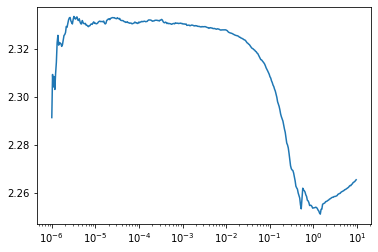

Epoch 1/20
1750/1750 [==============================] - 2s 991us/step - loss: 2.0460 - accuracy: 0.2837 - val_loss: 6.0721 - val_accuracy: 0.1013
Model: "OptimalLR_Adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 30)                23550     
                                                                 
 dense_5 (Dense)             (None, 20)                620       
                                                                 
 dense_6 (Dense)             (None, 10)                210       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
Total params: 24,490
Trainable params:

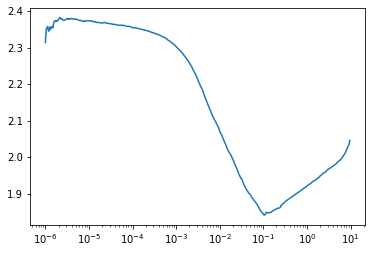

Epoch 1/20
1750/1750 [==============================] - 2s 946us/step - loss: 2.8191 - accuracy: 0.2344 - val_loss: 9.7637 - val_accuracy: 0.0993
Model: "OptimalLR_RMSprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_8 (Dense)             (None, 30)                23550     
                                                                 
 dense_9 (Dense)             (None, 20)                620       
                                                                 
 dense_10 (Dense)            (None, 10)                210       
                                                                 
 dense_11 (Dense)            (None, 10)                110       
                                                                 
Total params: 24,490
Trainable para

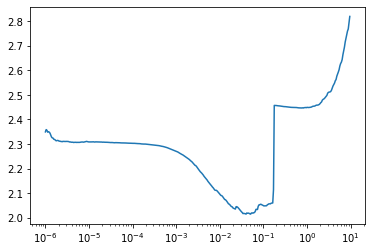

Epoch 1/20
1750/1750 [==============================] - 2s 866us/step - loss: 2.1923 - accuracy: 0.1871 - val_loss: 1.4882 - val_accuracy: 0.5540
Model: "OptimalLR_Adadelta"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 784)               0         
                                                                 
 dense_12 (Dense)            (None, 30)                23550     
                                                                 
 dense_13 (Dense)            (None, 20)                620       
                                                                 
 dense_14 (Dense)            (None, 10)                210       
                                                                 
 dense_15 (Dense)            (None, 10)                110       
                                                                 
Total params: 24,490
Trainable par

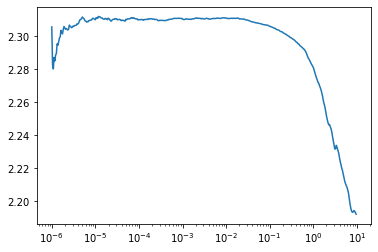

In [15]:
# Para cada par optimizador-nombre
for opt, optname in zip(optimizers, optimizer_names):
    lr_finder_steps = 400
    
    # Llamamos a la clase LRFind
    lr_find = LRFind(1e-6, 1e1, lr_finder_steps)

    #Entrenamos el modelo para obtener las gráficas y obtener los óptimos
    model, history = neuralNetwork("OptimalLR_" + optname, X_train, y_train, X_valid, y_valid, 
                                   [28,28], 10, 3, [30,20,10], epochs = 20, hidden_function = "relu", 
                                   output_function = "softmax", optimizer = opt, learning_rate = None, callbacks = [lr_find])
    plt.plot(lr_find.lrs, lr_find.losses)
    plt.xscale('log')
    plt.show()


Antes de nada, cabe volver a avisar de que los warnings no deben preocupar, son warnings relacionados con el hardware usado.

Respecto a los resultados, ya podemos obtener a simple vista un learning rate cercano al óptimo:

   * SGD: 0.1
   * Adam: 0.01
   * RMS-prop: 0.005
   * Adedelta: 1 (casualmente como recomiendan en su paper)

In [16]:
# Cargamos los optimizadores con los lr optimos
optimal_lr = [0.1, 0.01, 0.005, 1]

optimizers = []
optimizers.append(tf.keras.optimizers.SGD(learning_rate = 0.1))
optimizers.append(tf.keras.optimizers.Adam(learning_rate = 0.01))
optimizers.append(tf.keras.optimizers.RMSprop(learning_rate = 0.005))
optimizers.append(tf.keras.optimizers.Adadelta(learning_rate = 1))

### Entrenamiento del modelo, con todas las combinaciones de optimizadores y learning rates

In [17]:
models, model_names, histories = trainNeuralNetworks(X_train, y_train, X_valid, y_valid, 
                                        input_shape = [28, 28], 
                                        n_outputs = 10, 
                                        n_hidden_layers = 3, 
                                        neurons_factor = 10, 
                                        optimizers = optimizers, 
                                        optimizer_names = optimizer_names, 
                                        learning_rates = LR_schedules, 
                                        LR_names = LR_names)


Training NN: SGD Constant LR 3 hl 10 nf
Epoch 1/20
1750/1750 [==============================] - 5s 2ms/step - loss: 0.4224 - accuracy: 0.8705 - val_loss: 0.1824 - val_accuracy: 0.9500
Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1799 - accuracy: 0.9456 - val_loss: 0.1441 - val_accuracy: 0.9620
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1393 - accuracy: 0.9571 - val_loss: 0.1534 - val_accuracy: 0.9572
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1201 - accuracy: 0.9639 - val_loss: 0.1395 - val_accuracy: 0.9622
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1086 - accuracy: 0.9664 - val_loss: 0.1269 - val_accuracy: 0.9613
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0990 - accuracy: 0.9698 - val_loss: 0.1169 - val_accuracy: 0.9635
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0914 - accuracy: 0

1750/1750 [==============================] - 4s 2ms/step - loss: 0.4111 - accuracy: 0.8719 - val_loss: 0.2539 - val_accuracy: 0.9277
Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1961 - accuracy: 0.9422 - val_loss: 0.1713 - val_accuracy: 0.9540
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1568 - accuracy: 0.9537 - val_loss: 0.1651 - val_accuracy: 0.9532
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1371 - accuracy: 0.9608 - val_loss: 0.1516 - val_accuracy: 0.9575
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1239 - accuracy: 0.9630 - val_loss: 0.1502 - val_accuracy: 0.9605
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1130 - accuracy: 0.9667 - val_loss: 0.1320 - val_accuracy: 0.9622
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1057 - accuracy: 0.9685 - val_loss: 0.1373 - val_accuracy: 0.9605
Epo

Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.2208 - accuracy: 0.9356 - val_loss: 0.1625 - val_accuracy: 0.9530
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1923 - accuracy: 0.9447 - val_loss: 0.1727 - val_accuracy: 0.9477
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1809 - accuracy: 0.9487 - val_loss: 0.2001 - val_accuracy: 0.9490
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1636 - accuracy: 0.9548 - val_loss: 0.2014 - val_accuracy: 0.9473
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1556 - accuracy: 0.9577 - val_loss: 0.1723 - val_accuracy: 0.9535
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1501 - accuracy: 0.9597 - val_loss: 0.1831 - val_accuracy: 0.9528
Epoch 8/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.1458 - accuracy: 0.9602 - val_loss: 0.1679 - val_accuracy:

Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3247 - accuracy: 0.1011 - val_loss: 2.3163 - val_accuracy: 0.0948
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3245 - accuracy: 0.0999 - val_loss: 2.3376 - val_accuracy: 0.0993
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3238 - accuracy: 0.1014 - val_loss: 2.3133 - val_accuracy: 0.1082
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3245 - accuracy: 0.1024 - val_loss: 2.3192 - val_accuracy: 0.1110
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3228 - accuracy: 0.1030 - val_loss: 2.3304 - val_accuracy: 0.0980
Epoch 8/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3230 - accuracy: 0.1024 - val_loss: 2.3235 - val_accuracy: 0.1082
Epoch 9/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3244 - accuracy: 0.1027 - val_loss: 2.3078 - val_accuracy:

Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1686 - accuracy: 0.9566 - val_loss: 0.1951 - val_accuracy: 0.9567
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1709 - accuracy: 0.9578 - val_loss: 0.1983 - val_accuracy: 0.9590
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1716 - accuracy: 0.9579 - val_loss: 0.1913 - val_accuracy: 0.9582
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1819 - accuracy: 0.9581 - val_loss: 0.1753 - val_accuracy: 0.9620
Epoch 8/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1837 - accuracy: 0.9587 - val_loss: 0.2147 - val_accuracy: 0.9572
Epoch 9/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1866 - accuracy: 0.9590 - val_loss: 0.3165 - val_accuracy: 0.9635
Epoch 10/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1941 - accuracy: 0.9582 - val_loss: 0.2177 - val_accuracy

1750/1750 [==============================] - 4s 2ms/step - loss: 2.3288 - accuracy: 0.1013 - val_loss: 2.3392 - val_accuracy: 0.1110
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3279 - accuracy: 0.1010 - val_loss: 2.3156 - val_accuracy: 0.1082
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3271 - accuracy: 0.1005 - val_loss: 2.3136 - val_accuracy: 0.0980
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3259 - accuracy: 0.1032 - val_loss: 2.3211 - val_accuracy: 0.1075
Epoch 8/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3264 - accuracy: 0.1006 - val_loss: 2.3123 - val_accuracy: 0.0993
Epoch 9/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3258 - accuracy: 0.1021 - val_loss: 2.3270 - val_accuracy: 0.1075
Epoch 10/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3263 - accuracy: 0.1017 - val_loss: 2.3115 - val_accuracy: 0.1110
Ep

Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1133 - accuracy: 0.9663 - val_loss: 0.1195 - val_accuracy: 0.9643
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1035 - accuracy: 0.9694 - val_loss: 0.1153 - val_accuracy: 0.9653
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0952 - accuracy: 0.9720 - val_loss: 0.1122 - val_accuracy: 0.9680
Epoch 8/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0889 - accuracy: 0.9739 - val_loss: 0.1096 - val_accuracy: 0.9707
Epoch 9/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0833 - accuracy: 0.9754 - val_loss: 0.1131 - val_accuracy: 0.9678
Epoch 10/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0797 - accuracy: 0.9761 - val_loss: 0.1107 - val_accuracy: 0.9690
Epoch 11/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0753 - accuracy: 0.9774 - val_loss: 0.1060 - val_accurac

1750/1750 [==============================] - 4s 2ms/step - loss: 0.2176 - accuracy: 0.9371 - val_loss: 0.2030 - val_accuracy: 0.9427
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1978 - accuracy: 0.9423 - val_loss: 0.1862 - val_accuracy: 0.9467
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1830 - accuracy: 0.9464 - val_loss: 0.1800 - val_accuracy: 0.9480
Epoch 8/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1719 - accuracy: 0.9502 - val_loss: 0.1690 - val_accuracy: 0.9523
Epoch 9/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1620 - accuracy: 0.9527 - val_loss: 0.1618 - val_accuracy: 0.9540
Epoch 10/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1545 - accuracy: 0.9549 - val_loss: 0.1597 - val_accuracy: 0.9548
Epoch 11/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1477 - accuracy: 0.9561 - val_loss: 0.1519 - val_accuracy: 0.9557
E

In [18]:
# Añadimos los modelos a la lista de totales
all_models += models
all_histories += histories

### Visualizamos los históricos de entrenamientos

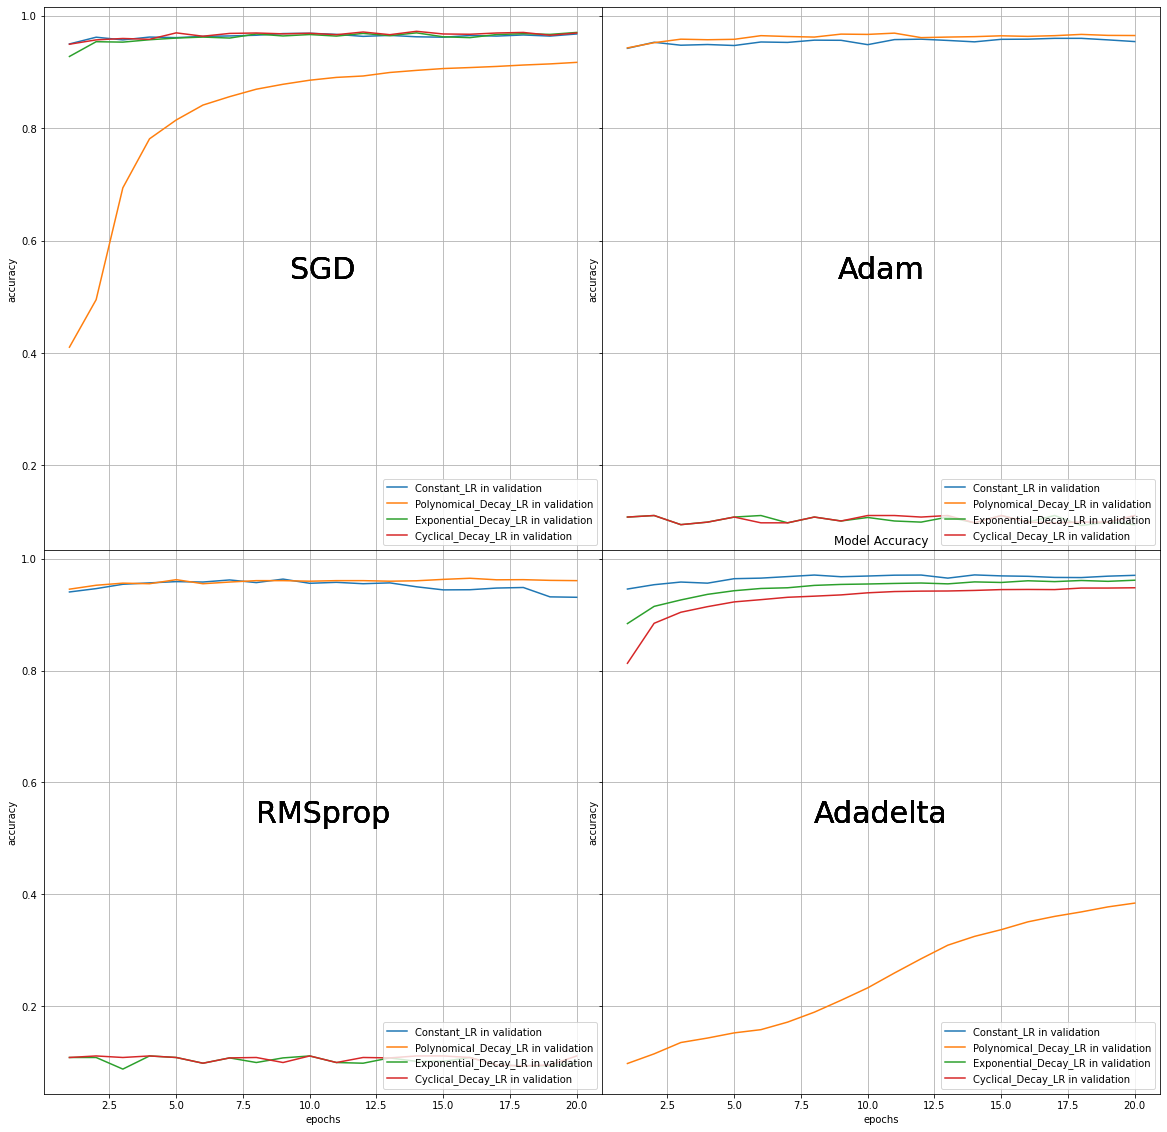

In [19]:
# Pintamos los historicos
plotHistories(histories, model_names, category_names = optimizer_names, subplot_names = LR_names, epochs = 20)

Vamos a analizar un poco qué resultados hemos obtenido. 

En general, hemos obtenido modelos bastante dispares, algunos muy buenos y otros muy malos. 

En SGD, vemos que todos los entrenamientos han sido bastante estables, excepto con decrecimiento polinómico, que parece que le ha costado más converger. Quizás le faltó entrenamiento. 

En Adam y RMSprop, con LR constante y decrecimiento polinómico, se han obtenido también muy buenos resultados y desde etapas muy tempranas, en cambio con decrecimiento exponencial y cíclico se han obtenido resultados absurdamente malos. 

En cuanto con Adadelta, con LR constante, y con descenso cíclico y exponencial, se han acabado consiguiendo resultados parecidos, si bien con LR constante desde etapas mucho más tempranas. Curiosamente, con decrecimiento polinómico del LR, parece que le ha faltado mucho entrenamiento para llegar a una buena puntuación.

### Usamos los modelos entrenados con el subset de test

In [20]:
# Pintamos las puntuaciones que obtiene cada modelo con el subset de tests, y nos quedamos con el mejor
best_model = getBestModel(models)

SGD_Constant_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1318 - accuracy: 0.9670
accuracy: 96.70%


SGD_Polynomical_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.3030 - accuracy: 0.9123
accuracy: 91.23%


SGD_Exponential_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1332 - accuracy: 0.9665
accuracy: 96.65%


SGD_Cyclical_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1435 - accuracy: 0.9661
accuracy: 96.61%


Adam_Constant_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.2197 - accuracy: 0.9493
accuracy: 94.93%


Adam_Polynomical_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1569 - accuracy: 0.9650
accuracy: 96.50%


Adam_Exponential_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 2.3210 - accuracy: 0.0980
accuracy: 9.80%


Adam_Cyclic

### Elegimos el mejor modelo

Best model: Adadelta_Constant_LR_3_hl_10_nf
Adadelta_Constant_LR_3_hl_10_nf: Classification report

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.98      0.96      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.97      0.96       892
           6       0.98      0.96      0.97       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.95      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Adadelta_Constant_LR_3_hl_10_nf: Confusion Matrix



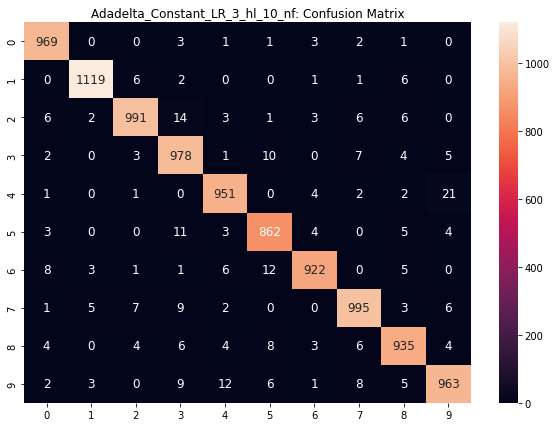

In [21]:
print("Best model: " + best_model.name)
plotModel(best_model, best_model.name, X_test, y_test)

Para nuestro modelo con 3 capas ocultas, con 30, 20 y 10 neuronas respectivamente, los hiperparámetros que mejor han funcionado han sido Adadelta como optimizador, y learning rate constante de 1, como recomiendan en el paper.

Se ha obtenido un average del 97%, un resultado estupendo teniendo en cuenta las pocas neuronas con las que se ha entrenado.

## Segundo modelo: 4 capas ocultas y factor de neuronas de 10: [40, 30, 20, 10] neuronas

### Búsqueda de learning rates óptimos para cada optimizador

In [22]:
# Cargamos los optimizadores que usaremos
optimizers = []
optimizers.append(tf.keras.optimizers.SGD())
optimizers.append(tf.keras.optimizers.Adam())
optimizers.append(tf.keras.optimizers.RMSprop())
optimizers.append(tf.keras.optimizers.Adadelta())
optimizer_names = ['SGD', 'Adam', 'RMSprop', 'Adadelta']

Epoch 1/20
1750/1750 [==============================] - 2s 861us/step - loss: 2.2627 - accuracy: 0.1335 - val_loss: 2.4887 - val_accuracy: 0.0875
Model: "OptimalLR_SGD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_20 (Flatten)        (None, 784)               0         
                                                                 
 dense_80 (Dense)            (None, 40)                31400     
                                                                 
 dense_81 (Dense)            (None, 30)                1230      
                                                                 
 dense_82 (Dense)            (None, 20)                620       
                                                                 
 dense_83 (Dense)            (None, 10)                210       
                                                                 
 dense_84 (Dense)            (None, 10)

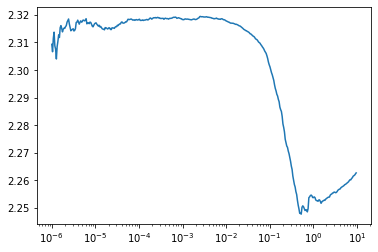

Epoch 1/20
1750/1750 [==============================] - 2s 1ms/step - loss: 2.0782 - accuracy: 0.2797 - val_loss: 6.0545 - val_accuracy: 0.1013
Model: "OptimalLR_Adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_21 (Flatten)        (None, 784)               0         
                                                                 
 dense_85 (Dense)            (None, 40)                31400     
                                                                 
 dense_86 (Dense)            (None, 30)                1230      
                                                                 
 dense_87 (Dense)            (None, 20)                620       
                                                                 
 dense_88 (Dense)            (None, 10)                210       
                                                                 
 dense_89 (Dense)            (None, 10) 

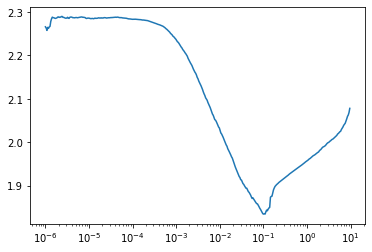

Epoch 1/20
1750/1750 [==============================] - 2s 984us/step - loss: 2.6018 - accuracy: 0.1941 - val_loss: 12.4659 - val_accuracy: 0.0980
Model: "OptimalLR_RMSprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_22 (Flatten)        (None, 784)               0         
                                                                 
 dense_90 (Dense)            (None, 40)                31400     
                                                                 
 dense_91 (Dense)            (None, 30)                1230      
                                                                 
 dense_92 (Dense)            (None, 20)                620       
                                                                 
 dense_93 (Dense)            (None, 10)                210       
                                                                 
 dense_94 (Dense)            (None

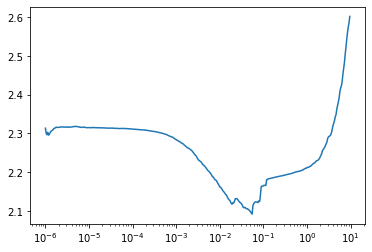

Epoch 1/20
1750/1750 [==============================] - 2s 901us/step - loss: 2.1966 - accuracy: 0.2130 - val_loss: 1.8209 - val_accuracy: 0.2767
Model: "OptimalLR_Adadelta"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_23 (Flatten)        (None, 784)               0         
                                                                 
 dense_95 (Dense)            (None, 40)                31400     
                                                                 
 dense_96 (Dense)            (None, 30)                1230      
                                                                 
 dense_97 (Dense)            (None, 20)                620       
                                                                 
 dense_98 (Dense)            (None, 10)                210       
                                                                 
 dense_99 (Dense)            (None

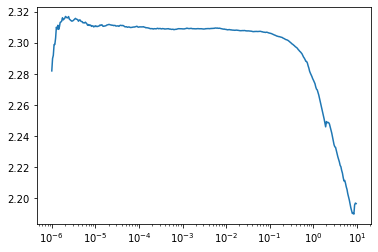

In [23]:
# Para cada par optimizador-nombre
for opt, optname in zip(optimizers, optimizer_names):
    lr_finder_steps = 400
    
    # Llamamos a la clase LRFind
    lr_find = LRFind(1e-6, 1e1, lr_finder_steps)

    #Entrenamos el modelo para obtener las gráficas y obtener los óptimos
    model, history = neuralNetwork("OptimalLR_" + optname, X_train, y_train, X_valid, y_valid, 
                                   [28,28], 10, 4, [40, 30,20,10], epochs = 20, hidden_function = "relu", 
                                   output_function = "softmax", optimizer = opt, learning_rate = None, callbacks = [lr_find])
    plt.plot(lr_find.lrs, lr_find.losses)
    plt.xscale('log')
    plt.show()


Hemos obtenido resultados muy parecidos al modelo anterior.

Respecto a los resultados, ya podemos obtener a simple vista un learning rate cercano al óptimo:

   * SGD: 0.1
   * Adam: 0.01
   * RMS-prop: 0.005
   * Adedelta: 1 (casualmente como recomiendan en su paper)

In [24]:
# Cargamos los optimizadores con los lr optimos
optimal_lr = [0.1, 0.01, 0.005, 1]

optimizers = []
optimizers.append(tf.keras.optimizers.SGD(learning_rate = 0.1))
optimizers.append(tf.keras.optimizers.Adam(learning_rate = 0.01))
optimizers.append(tf.keras.optimizers.RMSprop(learning_rate = 0.005))
optimizers.append(tf.keras.optimizers.Adadelta(learning_rate = 1))

### Entrenamiento del modelo, con todas las combinaciones de optimizadores y learning rates

In [25]:
models, model_names, histories = trainNeuralNetworks(X_train, y_train, X_valid, y_valid, 
                                        input_shape = [28, 28], 
                                        n_outputs = 10, 
                                        n_hidden_layers = 4, 
                                        neurons_factor = 10, 
                                        optimizers = optimizers, 
                                        optimizer_names = optimizer_names, 
                                        learning_rates = LR_schedules, 
                                        LR_names = LR_names)


Training NN: SGD Constant LR 4 hl 10 nf
Epoch 1/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.3973 - accuracy: 0.8772 - val_loss: 0.2017 - val_accuracy: 0.9448
Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1754 - accuracy: 0.9481 - val_loss: 0.1680 - val_accuracy: 0.9498
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1356 - accuracy: 0.9591 - val_loss: 0.1267 - val_accuracy: 0.9625
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1121 - accuracy: 0.9663 - val_loss: 0.1342 - val_accuracy: 0.9625
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0982 - accuracy: 0.9701 - val_loss: 0.1193 - val_accuracy: 0.9665
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0843 - accuracy: 0.9740 - val_loss: 0.1093 - val_accuracy: 0.9715
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0800 - accuracy: 0

Epoch 1/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.3870 - accuracy: 0.8806 - val_loss: 0.1854 - val_accuracy: 0.9485
Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1826 - accuracy: 0.9468 - val_loss: 0.1637 - val_accuracy: 0.9565
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1454 - accuracy: 0.9574 - val_loss: 0.1269 - val_accuracy: 0.9635
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1259 - accuracy: 0.9628 - val_loss: 0.1362 - val_accuracy: 0.9635
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1112 - accuracy: 0.9678 - val_loss: 0.1140 - val_accuracy: 0.9670
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0997 - accuracy: 0.9701 - val_loss: 0.1200 - val_accuracy: 0.9653
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0910 - accuracy: 0.9734 - val_loss: 0.1308 - val_accuracy:

Epoch 1/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.3755 - accuracy: 0.8919 - val_loss: 0.2538 - val_accuracy: 0.9352
Epoch 2/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.2142 - accuracy: 0.9437 - val_loss: 0.1818 - val_accuracy: 0.9530
Epoch 3/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.1819 - accuracy: 0.9533 - val_loss: 0.2190 - val_accuracy: 0.9492
Epoch 4/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.1654 - accuracy: 0.9573 - val_loss: 0.2094 - val_accuracy: 0.9467
Epoch 5/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.1498 - accuracy: 0.9626 - val_loss: 0.1829 - val_accuracy: 0.9542
Epoch 6/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.1410 - accuracy: 0.9645 - val_loss: 0.1609 - val_accuracy: 0.9640
Epoch 7/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.1344 - accuracy: 0.9667 - val_loss: 0.1706 - val_accuracy:

Epoch 1/20
1750/1750 [==============================] - 5s 3ms/step - loss: 5.5786 - accuracy: 0.1024 - val_loss: 2.3339 - val_accuracy: 0.1082
Epoch 2/20
1750/1750 [==============================] - 5s 3ms/step - loss: 2.3243 - accuracy: 0.1029 - val_loss: 2.3217 - val_accuracy: 0.1110
Epoch 3/20
1750/1750 [==============================] - 5s 3ms/step - loss: 2.3247 - accuracy: 0.1011 - val_loss: 2.3163 - val_accuracy: 0.0948
Epoch 4/20
1750/1750 [==============================] - 5s 3ms/step - loss: 2.3245 - accuracy: 0.0999 - val_loss: 2.3376 - val_accuracy: 0.0993
Epoch 5/20
1750/1750 [==============================] - 5s 3ms/step - loss: 2.3238 - accuracy: 0.1014 - val_loss: 2.3133 - val_accuracy: 0.1082
Epoch 6/20
1750/1750 [==============================] - 5s 3ms/step - loss: 2.3245 - accuracy: 0.1024 - val_loss: 2.3192 - val_accuracy: 0.1110
Epoch 7/20
1750/1750 [==============================] - 5s 3ms/step - loss: 2.3228 - accuracy: 0.1030 - val_loss: 2.3304 - val_accuracy:

Epoch 1/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.3580 - accuracy: 0.8936 - val_loss: 0.1952 - val_accuracy: 0.9470
Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.2079 - accuracy: 0.9445 - val_loss: 0.2016 - val_accuracy: 0.9507
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1846 - accuracy: 0.9528 - val_loss: 0.2163 - val_accuracy: 0.9492
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1844 - accuracy: 0.9547 - val_loss: 0.2164 - val_accuracy: 0.9515
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1874 - accuracy: 0.9570 - val_loss: 0.1997 - val_accuracy: 0.9572
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1932 - accuracy: 0.9571 - val_loss: 0.2113 - val_accuracy: 0.9495
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.2041 - accuracy: 0.9571 - val_loss: 0.3623 - val_accuracy:

Epoch 1/20
1750/1750 [==============================] - 5s 3ms/step - loss: 2.7649 - accuracy: 0.1016 - val_loss: 2.3413 - val_accuracy: 0.1082
Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3274 - accuracy: 0.1024 - val_loss: 2.3134 - val_accuracy: 0.1082
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3278 - accuracy: 0.1011 - val_loss: 2.3143 - val_accuracy: 0.0875
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3288 - accuracy: 0.1013 - val_loss: 2.3392 - val_accuracy: 0.1110
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3279 - accuracy: 0.1010 - val_loss: 2.3156 - val_accuracy: 0.1082
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3271 - accuracy: 0.1005 - val_loss: 2.3136 - val_accuracy: 0.0980
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 2.3259 - accuracy: 0.1032 - val_loss: 2.3211 - val_accuracy:

Epoch 1/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.3833 - accuracy: 0.8833 - val_loss: 0.2064 - val_accuracy: 0.9435
Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1823 - accuracy: 0.9470 - val_loss: 0.1570 - val_accuracy: 0.9530
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1399 - accuracy: 0.9588 - val_loss: 0.1473 - val_accuracy: 0.9603
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1164 - accuracy: 0.9662 - val_loss: 0.1329 - val_accuracy: 0.9647
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1008 - accuracy: 0.9706 - val_loss: 0.1256 - val_accuracy: 0.9670
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0901 - accuracy: 0.9740 - val_loss: 0.1203 - val_accuracy: 0.9660
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.0819 - accuracy: 0.9759 - val_loss: 0.1321 - val_accuracy:

Epoch 1/20
1750/1750 [==============================] - 5s 3ms/step - loss: 0.6645 - accuracy: 0.7898 - val_loss: 0.3266 - val_accuracy: 0.9107
Epoch 2/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.3104 - accuracy: 0.9108 - val_loss: 0.2583 - val_accuracy: 0.9287
Epoch 3/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.2528 - accuracy: 0.9273 - val_loss: 0.2163 - val_accuracy: 0.9400
Epoch 4/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.2169 - accuracy: 0.9395 - val_loss: 0.1949 - val_accuracy: 0.9457
Epoch 5/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1925 - accuracy: 0.9454 - val_loss: 0.1763 - val_accuracy: 0.9540
Epoch 6/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1750 - accuracy: 0.9504 - val_loss: 0.1617 - val_accuracy: 0.9557
Epoch 7/20
1750/1750 [==============================] - 4s 2ms/step - loss: 0.1612 - accuracy: 0.9544 - val_loss: 0.1568 - val_accuracy:

In [26]:
# Añadimos los modelos a la lista de totales
all_models += models
all_histories += histories

### Visualizamos los históricos de entrenamientos

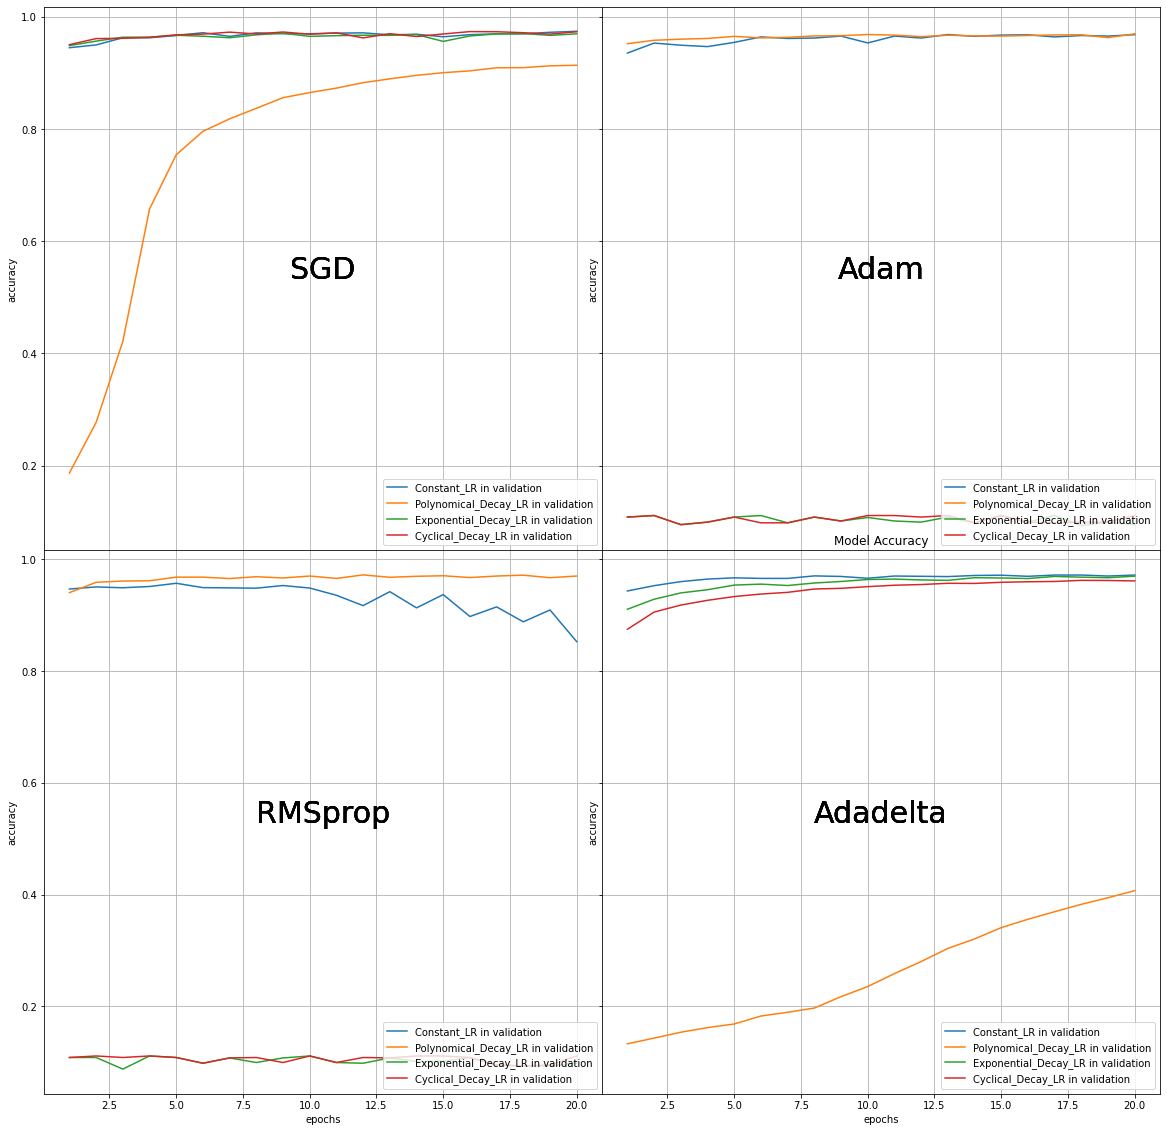

In [27]:
# Pintamos los historicos
plotHistories(histories, model_names, category_names = optimizer_names, subplot_names = LR_names, epochs = 20)

Resultados muy parecidos al caso anterior. La única diferencia relevante podría ser el overfitting obtenido en RMSprop con learning rate constante. Quizás lo habríamos remediado con early stopping.

### Usamos los modelos entrenados con el subset de test

In [28]:
# Obtenemos porcentajes de todos los modelos, y obtenemos el mejor
best_model = getBestModel(models)

SGD_Constant_LR_4_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1335 - accuracy: 0.9681
accuracy: 96.81%


SGD_Polynomical_Decay_LR_4_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.3161 - accuracy: 0.9070
accuracy: 90.70%


SGD_Exponential_Decay_LR_4_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1183 - accuracy: 0.9708
accuracy: 97.08%


SGD_Cyclical_Decay_LR_4_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1318 - accuracy: 0.9696
accuracy: 96.96%


Adam_Constant_LR_4_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1647 - accuracy: 0.9674
accuracy: 96.74%


Adam_Polynomical_Decay_LR_4_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1603 - accuracy: 0.9613
accuracy: 96.13%


Adam_Exponential_Decay_LR_4_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 2.3210 - accuracy: 0.0980
accuracy: 9.80%


Adam_Cyclic

### Elegimos el mejor modelo

Best model: Adadelta_Constant_LR_4_hl_10_nf
Adadelta_Constant_LR_4_hl_10_nf: Classification report

              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.97      0.97      0.97      1032
           3       0.95      0.97      0.96      1010
           4       0.97      0.97      0.97       982
           5       0.96      0.96      0.96       892
           6       0.99      0.97      0.98       958
           7       0.99      0.96      0.97      1028
           8       0.96      0.96      0.96       974
           9       0.96      0.97      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000

Adadelta_Constant_LR_4_hl_10_nf: Confusion Matrix



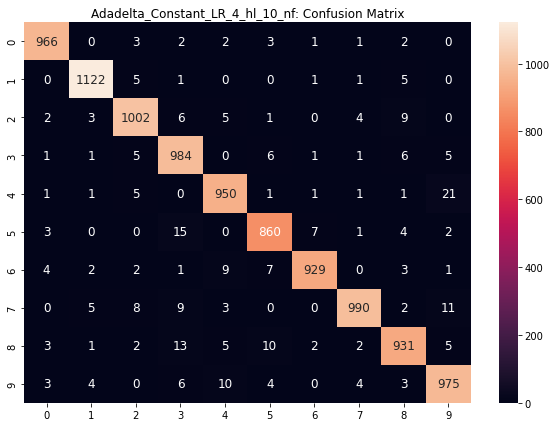

In [29]:
print("Best model: " + best_model.name)
plotModel(best_model, best_model.name, X_test, y_test)

El mejor modelo usando 4 capas ocultas con 40, 30, 20 y 10 neuronas cada una, ha sido usando Adadelta como optimizador, y un learning rate constante de 1. 

Un average del 97%, igual que en el caso anterior. Volvemos a comprobar que no hace falta un número desmesurado de neuronas para obtener resultados más que aceptables.

## Tercer modelo: 3 capas ocultas y factor de neuronas de 100: [300, 200, 100] neuronas

### Búsqueda de learning rates óptimos para cada optimizador

In [30]:
# Cargamos los optimizadores que usaremos
optimizers = []
optimizers.append(tf.keras.optimizers.SGD())
optimizers.append(tf.keras.optimizers.Adam())
optimizers.append(tf.keras.optimizers.RMSprop())
optimizers.append(tf.keras.optimizers.Adadelta())
optimizer_names = ['SGD', 'Adam', 'RMSprop', 'Adadelta']

Epoch 1/20
1750/1750 [==============================] - 2s 1ms/step - loss: nan - accuracy: 0.1995 - val_loss: nan - val_accuracy: 0.0948
Model: "OptimalLR_SGD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_40 (Flatten)        (None, 784)               0         
                                                                 
 dense_180 (Dense)           (None, 300)               235500    
                                                                 
 dense_181 (Dense)           (None, 200)               60200     
                                                                 
 dense_182 (Dense)           (None, 100)               20100     
                                                                 
 dense_183 (Dense)           (None, 10)                1010      
                                                                 
Total params: 316,810
Trainable params: 316,810

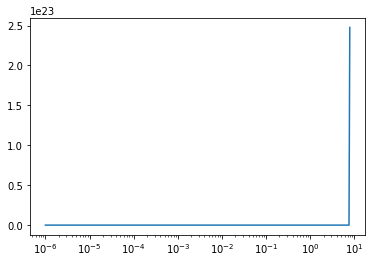

Epoch 1/20
1750/1750 [==============================] - 3s 1ms/step - loss: 2.5467 - accuracy: 0.3827 - val_loss: 5.2209 - val_accuracy: 0.1082
Model: "OptimalLR_Adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_41 (Flatten)        (None, 784)               0         
                                                                 
 dense_184 (Dense)           (None, 300)               235500    
                                                                 
 dense_185 (Dense)           (None, 200)               60200     
                                                                 
 dense_186 (Dense)           (None, 100)               20100     
                                                                 
 dense_187 (Dense)           (None, 10)                1010      
                                                                 
Total params: 316,810
Trainable params: 

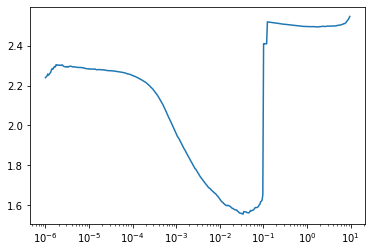

Epoch 1/20
1750/1750 [==============================] - 3s 2ms/step - loss: 4.9861 - accuracy: 0.2985 - val_loss: 12.7070 - val_accuracy: 0.0875
Model: "OptimalLR_RMSprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_42 (Flatten)        (None, 784)               0         
                                                                 
 dense_188 (Dense)           (None, 300)               235500    
                                                                 
 dense_189 (Dense)           (None, 200)               60200     
                                                                 
 dense_190 (Dense)           (None, 100)               20100     
                                                                 
 dense_191 (Dense)           (None, 10)                1010      
                                                                 
Total params: 316,810
Trainable para

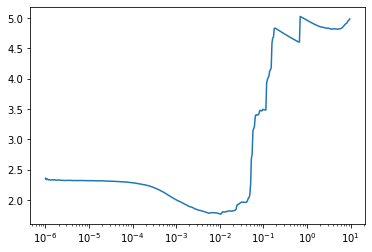

Epoch 1/20
1750/1750 [==============================] - 3s 2ms/step - loss: 2.0560 - accuracy: 0.2583 - val_loss: 5.5521 - val_accuracy: 0.0878
Model: "OptimalLR_Adadelta"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_43 (Flatten)        (None, 784)               0         
                                                                 
 dense_192 (Dense)           (None, 300)               235500    
                                                                 
 dense_193 (Dense)           (None, 200)               60200     
                                                                 
 dense_194 (Dense)           (None, 100)               20100     
                                                                 
 dense_195 (Dense)           (None, 10)                1010      
                                                                 
Total params: 316,810
Trainable para

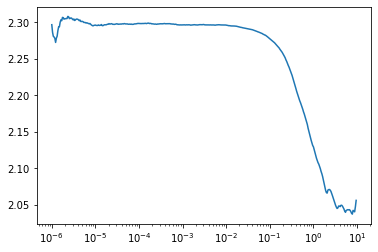

In [31]:
# Para cada par optimizador-nombre
for opt, optname in zip(optimizers, optimizer_names):
    lr_finder_steps = 400
    
    # Llamamos a la clase LRFind
    lr_find = LRFind(1e-6, 1e1, lr_finder_steps)

    #Entrenamos el modelo para obtener las gráficas y obtener los óptimos
    model, history = neuralNetwork("OptimalLR_" + optname, X_train, y_train, X_valid, y_valid, 
                                   [28,28], 10, 3, [300,200,100], epochs = 20, hidden_function = "relu",
                                   output_function = "softmax", optimizer = opt, learning_rate = None, callbacks = [lr_find])
    plt.plot(lr_find.lrs, lr_find.losses)
    plt.xscale('log')
    plt.show()


Antes de nada, cabe volver a avisar de que los warnings no deben preocupar, son warnings relacionados con el hardware usado.

Respecto a los resultados, ya podemos obtener a simple vista un learning rate cercano al óptimo:

   * SGD: Parece que no se ha calculado bien. Elegiremos 0.1
   * Adam: 0.001
   * RMS-prop: 0.001
   * Adedelta: 0.5

In [32]:
# Cargamos los optimizadores con los lr optimos
optimal_lr = [0.1, 0.001, 0.001, 0.5]

optimizers = []
optimizers.append(tf.keras.optimizers.SGD(learning_rate = 0.1))
optimizers.append(tf.keras.optimizers.Adam(learning_rate = 0.001))
optimizers.append(tf.keras.optimizers.RMSprop(learning_rate = 0.001))
optimizers.append(tf.keras.optimizers.Adadelta(learning_rate = 0.5))

### Entrenamiento del modelo, con todas las combinaciones de optimizadores y learning rates

In [33]:
models, model_names, histories = trainNeuralNetworks(X_train, y_train, X_valid, y_valid, 
                                        input_shape = [28, 28], 
                                        n_outputs = 10, 
                                        n_hidden_layers = 3, 
                                        neurons_factor = 100, 
                                        optimizers = optimizers, 
                                        optimizer_names = optimizer_names, 
                                        learning_rates = LR_schedules, 
                                        LR_names = LR_names)


Training NN: SGD Constant LR 3 hl 100 nf
Epoch 1/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.2640 - accuracy: 0.9194 - val_loss: 0.1211 - val_accuracy: 0.9660
Epoch 2/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.1026 - accuracy: 0.9680 - val_loss: 0.0894 - val_accuracy: 0.9755
Epoch 3/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0680 - accuracy: 0.9778 - val_loss: 0.1013 - val_accuracy: 0.9718
Epoch 4/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0480 - accuracy: 0.9844 - val_loss: 0.0875 - val_accuracy: 0.9755
Epoch 5/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0371 - accuracy: 0.9876 - val_loss: 0.0775 - val_accuracy: 0.9805
Epoch 6/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0267 - accuracy: 0.9917 - val_loss: 0.0730 - val_accuracy: 0.9805
Epoch 7/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0210 - accuracy: 

1750/1750 [==============================] - 7s 4ms/step - loss: 0.2491 - accuracy: 0.9210 - val_loss: 0.1301 - val_accuracy: 0.9635
Epoch 2/20
1750/1750 [==============================] - 6s 4ms/step - loss: 0.0998 - accuracy: 0.9683 - val_loss: 0.0987 - val_accuracy: 0.9718
Epoch 3/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0689 - accuracy: 0.9778 - val_loss: 0.0753 - val_accuracy: 0.9800
Epoch 4/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0492 - accuracy: 0.9845 - val_loss: 0.0850 - val_accuracy: 0.9772
Epoch 5/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0372 - accuracy: 0.9881 - val_loss: 0.0736 - val_accuracy: 0.9830
Epoch 6/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0306 - accuracy: 0.9901 - val_loss: 0.0715 - val_accuracy: 0.9805
Epoch 7/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0200 - accuracy: 0.9937 - val_loss: 0.0767 - val_accuracy: 0.9815
Epo

1750/1750 [==============================] - 8s 4ms/step - loss: 0.2147 - accuracy: 0.9342 - val_loss: 0.1130 - val_accuracy: 0.9680
Epoch 2/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0909 - accuracy: 0.9716 - val_loss: 0.0868 - val_accuracy: 0.9768
Epoch 3/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0653 - accuracy: 0.9799 - val_loss: 0.0814 - val_accuracy: 0.9768
Epoch 4/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0503 - accuracy: 0.9837 - val_loss: 0.1089 - val_accuracy: 0.9718
Epoch 5/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0394 - accuracy: 0.9874 - val_loss: 0.0784 - val_accuracy: 0.9762
Epoch 6/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0354 - accuracy: 0.9888 - val_loss: 0.0739 - val_accuracy: 0.9787
Epoch 7/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0302 - accuracy: 0.9906 - val_loss: 0.0833 - val_accuracy: 0.9795
Epo

Epoch 2/20
1750/1750 [==============================] - 7s 4ms/step - loss: 2.3241 - accuracy: 0.1026 - val_loss: 2.3216 - val_accuracy: 0.1110
Epoch 3/20
1750/1750 [==============================] - 6s 4ms/step - loss: 2.3247 - accuracy: 0.1011 - val_loss: 2.3163 - val_accuracy: 0.0948
Epoch 4/20
1750/1750 [==============================] - 6s 4ms/step - loss: 2.3245 - accuracy: 0.0999 - val_loss: 2.3376 - val_accuracy: 0.0993
Epoch 5/20
1750/1750 [==============================] - 6s 4ms/step - loss: 2.3238 - accuracy: 0.1014 - val_loss: 2.3133 - val_accuracy: 0.1082
Epoch 6/20
1750/1750 [==============================] - 7s 4ms/step - loss: 2.3245 - accuracy: 0.1024 - val_loss: 2.3192 - val_accuracy: 0.1110
Epoch 7/20
1750/1750 [==============================] - 6s 4ms/step - loss: 2.3228 - accuracy: 0.1030 - val_loss: 2.3304 - val_accuracy: 0.0980
Epoch 8/20
1750/1750 [==============================] - 6s 4ms/step - loss: 2.3230 - accuracy: 0.1024 - val_loss: 2.3235 - val_accuracy:

1750/1750 [==============================] - 9s 5ms/step - loss: 0.1040 - accuracy: 0.9705 - val_loss: 0.1335 - val_accuracy: 0.9705
Epoch 3/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0856 - accuracy: 0.9776 - val_loss: 0.1191 - val_accuracy: 0.9745
Epoch 4/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0745 - accuracy: 0.9819 - val_loss: 0.1388 - val_accuracy: 0.9753
Epoch 5/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0707 - accuracy: 0.9838 - val_loss: 0.0948 - val_accuracy: 0.9787
Epoch 6/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0680 - accuracy: 0.9854 - val_loss: 0.1039 - val_accuracy: 0.9775
Epoch 7/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0632 - accuracy: 0.9866 - val_loss: 0.1633 - val_accuracy: 0.9790
Epoch 8/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0591 - accuracy: 0.9875 - val_loss: 0.2049 - val_accuracy: 0.9720
Epo

1750/1750 [==============================] - 9s 5ms/step - loss: 2.4296 - accuracy: 0.1022 - val_loss: 2.3130 - val_accuracy: 0.1082
Epoch 3/20
1750/1750 [==============================] - 9s 5ms/step - loss: 2.3373 - accuracy: 0.1011 - val_loss: 2.3143 - val_accuracy: 0.0875
Epoch 4/20
1750/1750 [==============================] - 9s 5ms/step - loss: 2.3288 - accuracy: 0.1013 - val_loss: 2.3392 - val_accuracy: 0.1110
Epoch 5/20
1750/1750 [==============================] - 9s 5ms/step - loss: 2.3279 - accuracy: 0.1010 - val_loss: 2.3156 - val_accuracy: 0.1082
Epoch 6/20
1750/1750 [==============================] - 9s 5ms/step - loss: 2.3271 - accuracy: 0.1005 - val_loss: 2.3136 - val_accuracy: 0.0980
Epoch 7/20
1750/1750 [==============================] - 9s 5ms/step - loss: 2.3259 - accuracy: 0.1032 - val_loss: 2.3211 - val_accuracy: 0.1075
Epoch 8/20
1750/1750 [==============================] - 9s 5ms/step - loss: 2.3264 - accuracy: 0.1006 - val_loss: 2.3123 - val_accuracy: 0.0993
Epo

Epoch 3/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0671 - accuracy: 0.9795 - val_loss: 0.0881 - val_accuracy: 0.9750
Epoch 4/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0483 - accuracy: 0.9853 - val_loss: 0.0781 - val_accuracy: 0.9775
Epoch 5/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0362 - accuracy: 0.9886 - val_loss: 0.0661 - val_accuracy: 0.9810
Epoch 6/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0275 - accuracy: 0.9913 - val_loss: 0.0629 - val_accuracy: 0.9808
Epoch 7/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0211 - accuracy: 0.9937 - val_loss: 0.0690 - val_accuracy: 0.9797
Epoch 8/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0155 - accuracy: 0.9955 - val_loss: 0.0743 - val_accuracy: 0.9803
Epoch 9/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0116 - accuracy: 0.9967 - val_loss: 0.0751 - val_accuracy:

1750/1750 [==============================] - 7s 4ms/step - loss: 0.1086 - accuracy: 0.9679 - val_loss: 0.1073 - val_accuracy: 0.9700
Epoch 4/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0850 - accuracy: 0.9753 - val_loss: 0.0958 - val_accuracy: 0.9707
Epoch 5/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0687 - accuracy: 0.9795 - val_loss: 0.0831 - val_accuracy: 0.9740
Epoch 6/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0565 - accuracy: 0.9837 - val_loss: 0.0747 - val_accuracy: 0.9758
Epoch 7/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0473 - accuracy: 0.9865 - val_loss: 0.0767 - val_accuracy: 0.9760
Epoch 8/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0401 - accuracy: 0.9883 - val_loss: 0.0747 - val_accuracy: 0.9778
Epoch 9/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0340 - accuracy: 0.9905 - val_loss: 0.0755 - val_accuracy: 0.9790
Epo

In [34]:
# Añadimos los modelos a la lista de totales
all_models += models
all_histories += histories

### Visualizamos los históricos de entrenamientos

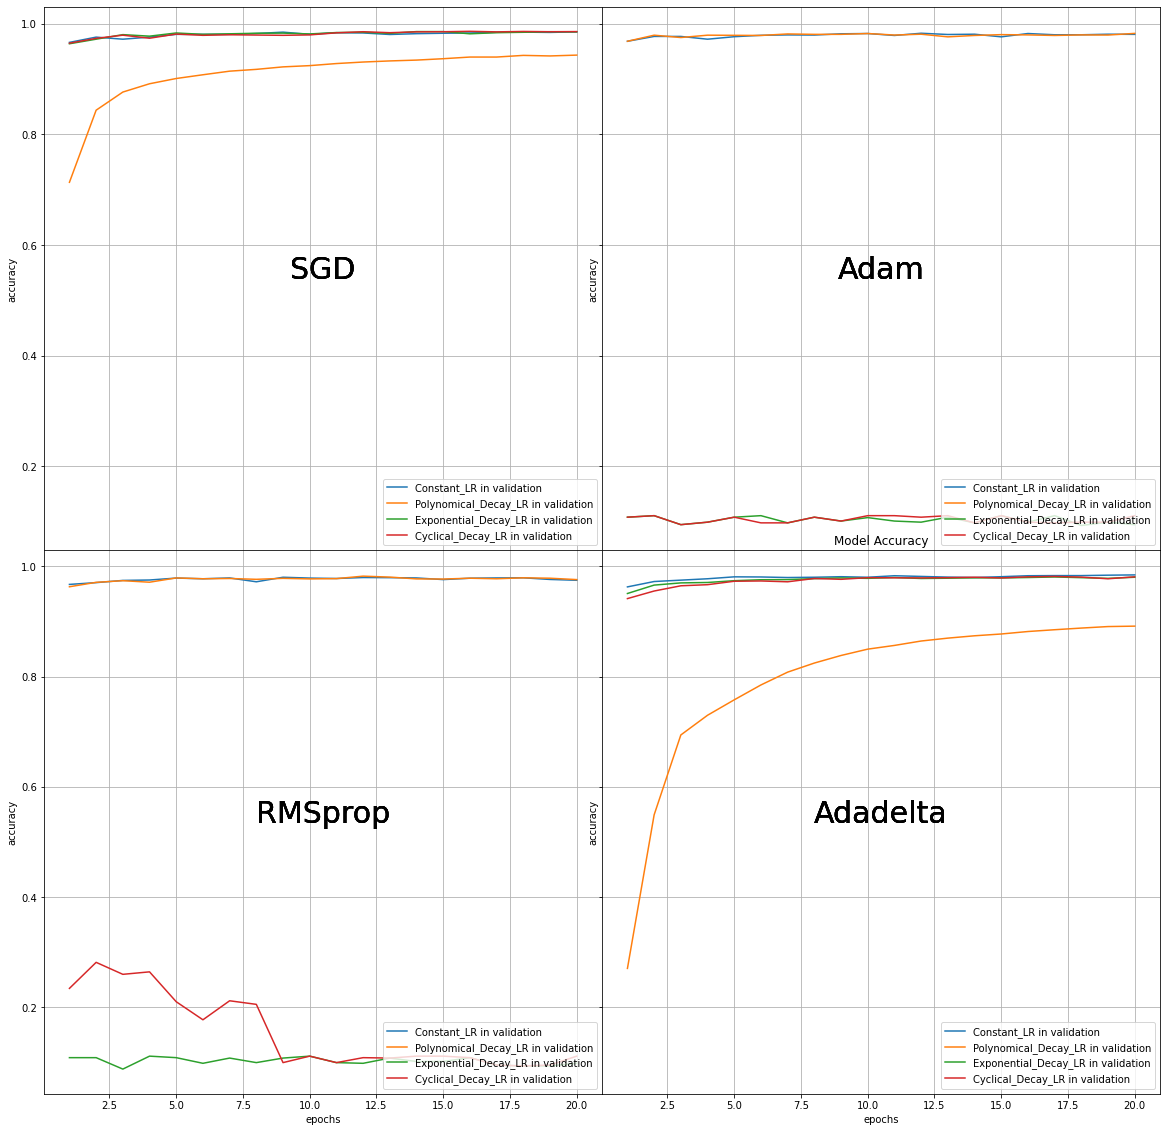

In [35]:
# Pintamos los historicos
plotHistories(histories, model_names, category_names = optimizer_names, subplot_names = LR_names, epochs = 20)

Las gráficas obtenidas reflejan que los entrenamientos son muy similares que en los entrenaminetos de modelos con muchas menos neuronas.

Las únicas diferencias relevantes son que en SGD y Adadelta, con decrecimiento polinómico de learning rate, se ha llegado en fases más tempranas a un buen accuracy, aunque siguen sin llegar a igualar al resto de schedulers de LR. 

En SGD, con LR constante, con decrecimiento cíclico, y decrecimiento exponencial, la evolución ha sido prácticamente la misma. Pasa igual en Adam, con LR constante y con decrecimiento polinómico.

### Usamos los modelos entrenados con el subset de test

In [36]:
# Obtenemos porcentajes de todos los modelos, y obtenemos el mejor
best_model = getBestModel(models)

SGD_Constant_LR_3_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.0742 - accuracy: 0.9849
accuracy: 98.49%


SGD_Polynomical_Decay_LR_3_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.2054 - accuracy: 0.9408
accuracy: 94.08%


SGD_Exponential_Decay_LR_3_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.0802 - accuracy: 0.9859
accuracy: 98.59%


SGD_Cyclical_Decay_LR_3_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.0806 - accuracy: 0.9835
accuracy: 98.35%


Adam_Constant_LR_3_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.1159 - accuracy: 0.9800
accuracy: 98.00%


Adam_Polynomical_Decay_LR_3_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.1100 - accuracy: 0.9804
accuracy: 98.04%


Adam_Exponential_Decay_LR_3_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 2.3210 - accuracy: 0.0980
accuracy: 9.80%


Adam

### Elegimos el mejor modelo

Best model: SGD_Exponential_Decay_LR_3_hl_100_nf
SGD_Exponential_Decay_LR_3_hl_100_nf: Classification report

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       980
           1       0.99      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.98      0.98      0.98      1028
           8       0.99      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

SGD_Exponential_Decay_LR_3_hl_100_nf: Confusion Matrix



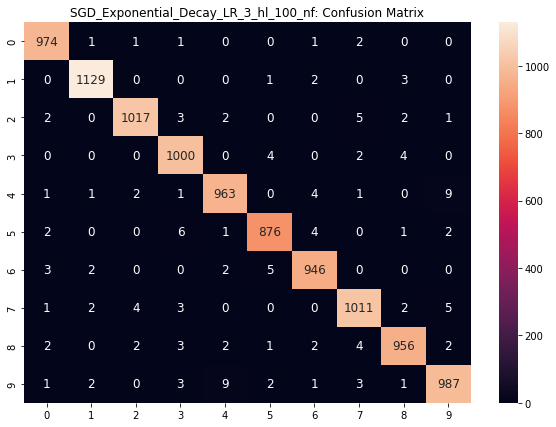

In [37]:
print("Best model: " + best_model.name)
plotModel(best_model, best_model.name, X_test, y_test)

En este caso, con SGD y decrecimiento exponencial, nuestro modelo de 3 capas ocultas y 300, 200 y 100 neuronas, ha mejorado a los dos anteriores, con un 99% de average. Si nos fijamos en la matriz de confusión, vemos que la mayor confusión ha sido la del 9 y el 4 con 9 casos. 9 entre miles en el peor de los casos, reflejo de un entreno muy bueno.

## Cuarto modelo: 4 capas ocultas y factor de neuronas de 100: [400, 300, 200, 100] neuronas

### Búsqueda de learning rates óptimos para cada optimizador

In [38]:
# Cargamos los optimizadores que usaremos
optimizers = []
optimizers.append(tf.keras.optimizers.SGD())
optimizers.append(tf.keras.optimizers.Adam())
optimizers.append(tf.keras.optimizers.RMSprop())
optimizers.append(tf.keras.optimizers.Adadelta())
optimizer_names = ['SGD', 'Adam', 'RMSprop', 'Adadelta']

Epoch 1/20
1750/1750 [==============================] - 3s 1ms/step - loss: nan - accuracy: 0.2045 - val_loss: nan - val_accuracy: 0.0948
Model: "OptimalLR_SGD"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_60 (Flatten)        (None, 784)               0         
                                                                 
 dense_260 (Dense)           (None, 400)               314000    
                                                                 
 dense_261 (Dense)           (None, 300)               120300    
                                                                 
 dense_262 (Dense)           (None, 200)               60200     
                                                                 
 dense_263 (Dense)           (None, 100)               20100     
                                                                 
 dense_264 (Dense)           (None, 10)        

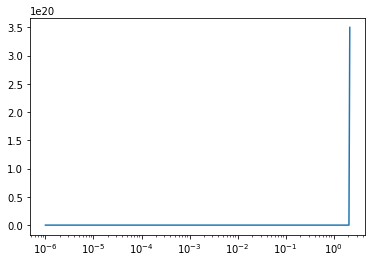

Epoch 1/20
1750/1750 [==============================] - 3s 2ms/step - loss: 2.0364 - accuracy: 0.3651 - val_loss: 11.9404 - val_accuracy: 0.0875
Model: "OptimalLR_Adam"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_61 (Flatten)        (None, 784)               0         
                                                                 
 dense_265 (Dense)           (None, 400)               314000    
                                                                 
 dense_266 (Dense)           (None, 300)               120300    
                                                                 
 dense_267 (Dense)           (None, 200)               60200     
                                                                 
 dense_268 (Dense)           (None, 100)               20100     
                                                                 
 dense_269 (Dense)           (None, 10)

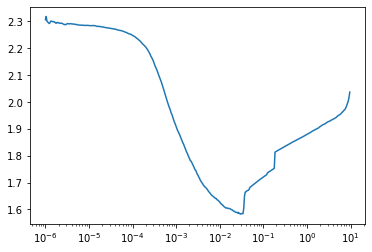

Epoch 1/20
1750/1750 [==============================] - 4s 2ms/step - loss: 586.6014 - accuracy: 0.2770 - val_loss: 14.6516 - val_accuracy: 0.0980
Model: "OptimalLR_RMSprop"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_62 (Flatten)        (None, 784)               0         
                                                                 
 dense_270 (Dense)           (None, 400)               314000    
                                                                 
 dense_271 (Dense)           (None, 300)               120300    
                                                                 
 dense_272 (Dense)           (None, 200)               60200     
                                                                 
 dense_273 (Dense)           (None, 100)               20100     
                                                                 
 dense_274 (Dense)           (None

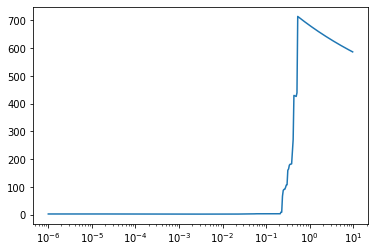

Epoch 1/20
1750/1750 [==============================] - 3s 2ms/step - loss: 2.0895 - accuracy: 0.2626 - val_loss: 1.8666 - val_accuracy: 0.3067
Model: "OptimalLR_Adadelta"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_63 (Flatten)        (None, 784)               0         
                                                                 
 dense_275 (Dense)           (None, 400)               314000    
                                                                 
 dense_276 (Dense)           (None, 300)               120300    
                                                                 
 dense_277 (Dense)           (None, 200)               60200     
                                                                 
 dense_278 (Dense)           (None, 100)               20100     
                                                                 
 dense_279 (Dense)           (None, 

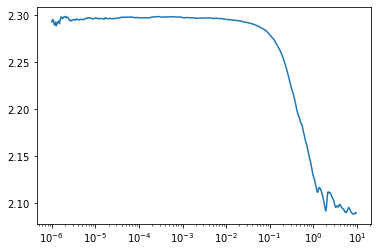

In [39]:
# Para cada par optimizador-nombre
for opt, optname in zip(optimizers, optimizer_names):
    lr_finder_steps = 400
    
    # Llamamos a la clase LRFind
    lr_find = LRFind(1e-6, 1e1, lr_finder_steps)

    #Entrenamos el modelo para obtener las gráficas y obtener los óptimos
    model, history = neuralNetwork("OptimalLR_" + optname, X_train, y_train, X_valid, y_valid, 
                                   [28,28], 10, 4, [400,300,200,100], epochs = 20, hidden_function = "relu", 
                                   output_function = "softmax", optimizer = opt, learning_rate = None, callbacks = [lr_find])
    plt.plot(lr_find.lrs, lr_find.losses)
    plt.xscale('log')
    plt.show()


Antes de nada, cabe volver a avisar de que los warnings no deben preocupar, son warnings relacionados con el hardware usado.

Respecto a los resultados, ya podemos obtener a simple vista un learning rate cercano al óptimo:

   * SGD: No se ve claro, elegimos 0.1
   * Adam: 0.001
   * RMS-prop: No se ve claro, elegimos 0.001
   * Adedelta: Justo en 1 se vuelve inestable, elegiremos 0.5

In [40]:
# Cargamos los optimizadores con los lr optimos
optimal_lr = [0.1, 0.001, 0.001, 0.5]

optimizers = []
optimizers.append(tf.keras.optimizers.SGD(learning_rate = 0.1))
optimizers.append(tf.keras.optimizers.Adam(learning_rate = 0.001))
optimizers.append(tf.keras.optimizers.RMSprop(learning_rate = 0.001))
optimizers.append(tf.keras.optimizers.Adadelta(learning_rate = 0.5))

### Entrenamiento del modelo, con todas las combinaciones de optimizadores y learning rates

In [41]:
models, model_names, histories = trainNeuralNetworks(X_train, y_train, X_valid, y_valid, 
                                        input_shape = [28, 28], 
                                        n_outputs = 10, 
                                        n_hidden_layers = 4, 
                                        neurons_factor = 100, 
                                        optimizers = optimizers, 
                                        optimizer_names = optimizer_names, 
                                        learning_rates = LR_schedules, 
                                        LR_names = LR_names)


Training NN: SGD Constant LR 4 hl 100 nf
Epoch 1/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.2629 - accuracy: 0.9188 - val_loss: 0.1626 - val_accuracy: 0.9520
Epoch 2/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.1004 - accuracy: 0.9680 - val_loss: 0.0913 - val_accuracy: 0.9728
Epoch 3/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0668 - accuracy: 0.9788 - val_loss: 0.0777 - val_accuracy: 0.9790
Epoch 4/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0470 - accuracy: 0.9850 - val_loss: 0.0836 - val_accuracy: 0.9765
Epoch 5/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0355 - accuracy: 0.9885 - val_loss: 0.0723 - val_accuracy: 0.9803
Epoch 6/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0264 - accuracy: 0.9912 - val_loss: 0.0777 - val_accuracy: 0.9793
Epoch 7/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0226 - accuracy: 

Epoch 1/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.2704 - accuracy: 0.9151 - val_loss: 0.1295 - val_accuracy: 0.9625
Epoch 2/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.1045 - accuracy: 0.9679 - val_loss: 0.0887 - val_accuracy: 0.9758
Epoch 3/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0696 - accuracy: 0.9776 - val_loss: 0.0762 - val_accuracy: 0.9768
Epoch 4/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0510 - accuracy: 0.9842 - val_loss: 0.0827 - val_accuracy: 0.9750
Epoch 5/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0395 - accuracy: 0.9872 - val_loss: 0.0883 - val_accuracy: 0.9787
Epoch 6/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0330 - accuracy: 0.9896 - val_loss: 0.0985 - val_accuracy: 0.9740
Epoch 7/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0265 - accuracy: 0.9914 - val_loss: 0.0744 - val_accuracy:

Epoch 1/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.2148 - accuracy: 0.9346 - val_loss: 0.1099 - val_accuracy: 0.9700
Epoch 2/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0961 - accuracy: 0.9709 - val_loss: 0.0921 - val_accuracy: 0.9750
Epoch 3/20
1750/1750 [==============================] - 8s 5ms/step - loss: 0.0711 - accuracy: 0.9787 - val_loss: 0.0968 - val_accuracy: 0.9730
Epoch 4/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0559 - accuracy: 0.9827 - val_loss: 0.0929 - val_accuracy: 0.9743
Epoch 5/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0432 - accuracy: 0.9866 - val_loss: 0.0814 - val_accuracy: 0.9800
Epoch 6/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0394 - accuracy: 0.9876 - val_loss: 0.0847 - val_accuracy: 0.9787
Epoch 7/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0337 - accuracy: 0.9898 - val_loss: 0.0885 - val_accuracy:

Epoch 1/20
1750/1750 [==============================] - 9s 5ms/step - loss: 9944.4004 - accuracy: 0.1024 - val_loss: 2.3339 - val_accuracy: 0.1082
Epoch 2/20
1750/1750 [==============================] - 8s 5ms/step - loss: 2.3240 - accuracy: 0.1029 - val_loss: 2.3216 - val_accuracy: 0.1110
Epoch 3/20
1750/1750 [==============================] - 8s 5ms/step - loss: 2.3247 - accuracy: 0.1012 - val_loss: 2.3163 - val_accuracy: 0.0948
Epoch 4/20
1750/1750 [==============================] - 8s 5ms/step - loss: 2.3245 - accuracy: 0.1000 - val_loss: 2.3376 - val_accuracy: 0.0993
Epoch 5/20
1750/1750 [==============================] - 8s 5ms/step - loss: 2.3238 - accuracy: 0.1014 - val_loss: 2.3133 - val_accuracy: 0.1082
Epoch 6/20
1750/1750 [==============================] - 8s 5ms/step - loss: 2.3245 - accuracy: 0.1024 - val_loss: 2.3192 - val_accuracy: 0.1110
Epoch 7/20
1750/1750 [==============================] - 8s 5ms/step - loss: 2.3227 - accuracy: 0.1030 - val_loss: 2.3304 - val_accura

Epoch 1/20
1750/1750 [==============================] - 12s 7ms/step - loss: 0.2315 - accuracy: 0.9303 - val_loss: 0.1506 - val_accuracy: 0.9640
Epoch 2/20
1750/1750 [==============================] - 11s 7ms/step - loss: 0.1271 - accuracy: 0.9675 - val_loss: 0.1311 - val_accuracy: 0.9682
Epoch 3/20
1750/1750 [==============================] - 11s 7ms/step - loss: 0.1162 - accuracy: 0.9737 - val_loss: 0.1351 - val_accuracy: 0.9697
Epoch 4/20
1750/1750 [==============================] - 11s 7ms/step - loss: 0.1064 - accuracy: 0.9767 - val_loss: 0.1676 - val_accuracy: 0.9697
Epoch 5/20
1750/1750 [==============================] - 11s 7ms/step - loss: 0.1098 - accuracy: 0.9779 - val_loss: 0.1251 - val_accuracy: 0.9758
Epoch 6/20
1750/1750 [==============================] - 12s 7ms/step - loss: 0.1007 - accuracy: 0.9806 - val_loss: 0.1723 - val_accuracy: 0.9715
Epoch 7/20
1750/1750 [==============================] - 11s 6ms/step - loss: 0.1062 - accuracy: 0.9814 - val_loss: 0.1358 - val_ac

Epoch 1/20
1750/1750 [==============================] - 12s 7ms/step - loss: 4768.6245 - accuracy: 0.1040 - val_loss: 2.4398 - val_accuracy: 0.1082
Epoch 2/20
1750/1750 [==============================] - 11s 7ms/step - loss: 73.1886 - accuracy: 0.1024 - val_loss: 2.3134 - val_accuracy: 0.1082
Epoch 3/20
1750/1750 [==============================] - 11s 7ms/step - loss: 2.3278 - accuracy: 0.1011 - val_loss: 2.3143 - val_accuracy: 0.0875
Epoch 4/20
1750/1750 [==============================] - 11s 6ms/step - loss: 2.3288 - accuracy: 0.1013 - val_loss: 2.3392 - val_accuracy: 0.1110
Epoch 5/20
1750/1750 [==============================] - 11s 7ms/step - loss: 2.3279 - accuracy: 0.1010 - val_loss: 2.3156 - val_accuracy: 0.1082
Epoch 6/20
1750/1750 [==============================] - 11s 7ms/step - loss: 2.3271 - accuracy: 0.1005 - val_loss: 2.3136 - val_accuracy: 0.0980
Epoch 7/20
1750/1750 [==============================] - 11s 6ms/step - loss: 2.3259 - accuracy: 0.1032 - val_loss: 2.3211 - va

Epoch 1/20
1750/1750 [==============================] - 10s 5ms/step - loss: 0.2311 - accuracy: 0.9288 - val_loss: 0.1148 - val_accuracy: 0.9665
Epoch 2/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0892 - accuracy: 0.9724 - val_loss: 0.0811 - val_accuracy: 0.9760
Epoch 3/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0566 - accuracy: 0.9824 - val_loss: 0.0915 - val_accuracy: 0.9732
Epoch 4/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0394 - accuracy: 0.9877 - val_loss: 0.0881 - val_accuracy: 0.9758
Epoch 5/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0284 - accuracy: 0.9914 - val_loss: 0.0707 - val_accuracy: 0.9822
Epoch 6/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0198 - accuracy: 0.9936 - val_loss: 0.0893 - val_accuracy: 0.9770
Epoch 7/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0143 - accuracy: 0.9956 - val_loss: 0.0787 - val_accuracy

Epoch 1/20
1750/1750 [==============================] - 10s 6ms/step - loss: 0.2963 - accuracy: 0.9123 - val_loss: 0.1411 - val_accuracy: 0.9603
Epoch 2/20
1750/1750 [==============================] - 10s 6ms/step - loss: 0.1259 - accuracy: 0.9615 - val_loss: 0.1027 - val_accuracy: 0.9703
Epoch 3/20
1750/1750 [==============================] - 10s 6ms/step - loss: 0.0854 - accuracy: 0.9740 - val_loss: 0.1004 - val_accuracy: 0.9682
Epoch 4/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0639 - accuracy: 0.9808 - val_loss: 0.0852 - val_accuracy: 0.9735
Epoch 5/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0488 - accuracy: 0.9851 - val_loss: 0.0758 - val_accuracy: 0.9797
Epoch 6/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0379 - accuracy: 0.9883 - val_loss: 0.0685 - val_accuracy: 0.9803
Epoch 7/20
1750/1750 [==============================] - 9s 5ms/step - loss: 0.0294 - accuracy: 0.9916 - val_loss: 0.0744 - val_accura

In [42]:
# Añadimos los modelos a la lista de totales
all_models += models
all_histories += histories

### Visualizamos los históricos de entrenamientos

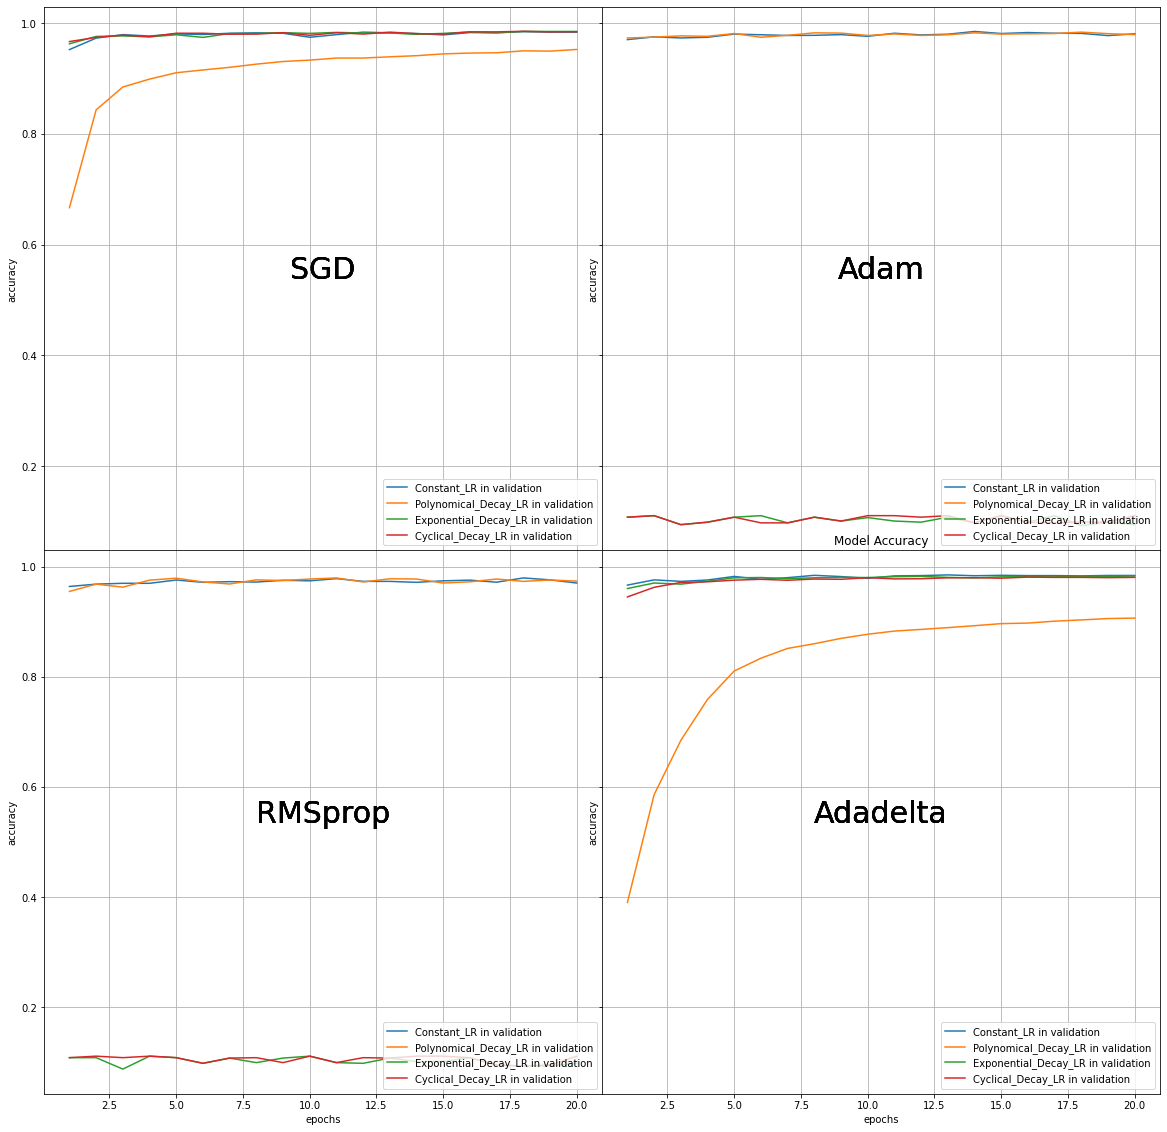

In [43]:
# Pintamos los historicos
plotHistories(histories, model_names, category_names = optimizer_names, subplot_names = LR_names, epochs = 20)

Resultados prácticamente calcados a los del modelo anterior. En este caso, podríamos decir que el número de capas no afecta cuando tenemos un gran número de neuronas.

### Usamos los modelos entrenados con el subset de test

In [44]:
best_model = getBestModel(models)

SGD_Constant_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.0883 - accuracy: 0.9849
accuracy: 98.49%


SGD_Polynomical_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.1813 - accuracy: 0.9477
accuracy: 94.77%


SGD_Exponential_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.0777 - accuracy: 0.9867
accuracy: 98.67%


SGD_Cyclical_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.0699 - accuracy: 0.9865
accuracy: 98.65%


Adam_Constant_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.1175 - accuracy: 0.9793
accuracy: 97.93%


Adam_Polynomical_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.1272 - accuracy: 0.9793
accuracy: 97.93%


Adam_Exponential_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 2.3210 - accuracy: 0.0980
accuracy: 9.80%


Adam

### Elegimos el mejor modelo

Best model: SGD_Exponential_Decay_LR_4_hl_100_nf
SGD_Exponential_Decay_LR_4_hl_100_nf: Classification report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

SGD_Exponential_Decay_LR_4_hl_100_nf: Confusion Matrix



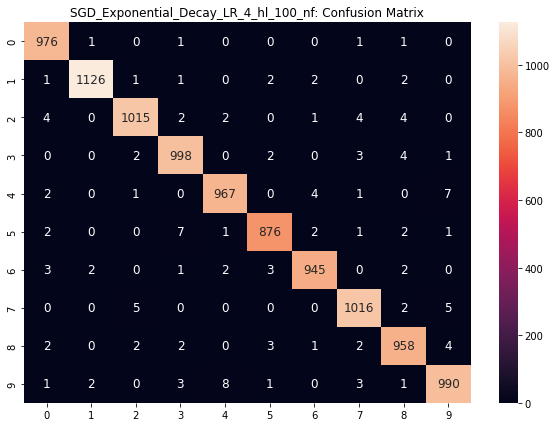

In [45]:
print("Best model: " + best_model.name)
plotModel(best_model, best_model.name, X_test, y_test)

El mejor modelo con 4 capas de 400, 300, 200 y 100 neuronas en cada una, ha sido el modelo que usa SGD como optimizador y learning rate con decrecimiento exponencial.

Se ha obtenido una puntuación del 99% de media, una puntuación excelente. Basta con echar un vistazo a la matriz de confusión para ver la cantidad de ceros que hay.



# Conclusiones y mejor modelo global

De entre todos los modelos entrenados, vamos a elegir al que mejor se ha comportado con el subset de tests. Primero, vamos a ver cuantos modelos distintos tenemos entrenados.

In [46]:
len(all_models)

64

64 modelos distintos, cada uno con una selección de hiperparámetros única. Elijamos al mejor.

In [47]:
best_model = getBestModel(all_models)

SGD_Constant_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1318 - accuracy: 0.9670
accuracy: 96.70%


SGD_Polynomical_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.3030 - accuracy: 0.9123
accuracy: 91.23%


SGD_Exponential_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1332 - accuracy: 0.9665
accuracy: 96.65%


SGD_Cyclical_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1435 - accuracy: 0.9661
accuracy: 96.61%


Adam_Constant_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.2197 - accuracy: 0.9493
accuracy: 94.93%


Adam_Polynomical_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 0.1569 - accuracy: 0.9650
accuracy: 96.50%


Adam_Exponential_Decay_LR_3_hl_10_nf
313/313 [==============================] - 1s 2ms/step - loss: 2.3210 - accuracy: 0.0980
accuracy: 9.80%


Adam_Cyclic

313/313 [==============================] - 1s 3ms/step - loss: 0.5783 - accuracy: 0.9760
accuracy: 97.60%


RMSprop_Exponential_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 2.3284 - accuracy: 0.1010
accuracy: 10.10%


RMSprop_Cyclical_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 2.3187 - accuracy: 0.1135
accuracy: 11.35%


Adadelta_Constant_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.1015 - accuracy: 0.9851
accuracy: 98.51%


Adadelta_Polynomical_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.3508 - accuracy: 0.9077
accuracy: 90.77%


Adadelta_Exponential_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.0964 - accuracy: 0.9816
accuracy: 98.16%


Adadelta_Cyclical_Decay_LR_4_hl_100_nf
313/313 [==============================] - 1s 3ms/step - loss: 0.0815 - accuracy: 0.9800
accuracy: 98.00%




Best model: SGD_Exponential_Decay_LR_4_hl_100_nf
SGD_Exponential_Decay_LR_4_hl_100_nf: Classification report

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.98      0.99      1032
           3       0.98      0.99      0.99      1010
           4       0.99      0.98      0.99       982
           5       0.99      0.98      0.98       892
           6       0.99      0.99      0.99       958
           7       0.99      0.99      0.99      1028
           8       0.98      0.98      0.98       974
           9       0.98      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

SGD_Exponential_Decay_LR_4_hl_100_nf: Confusion Matrix



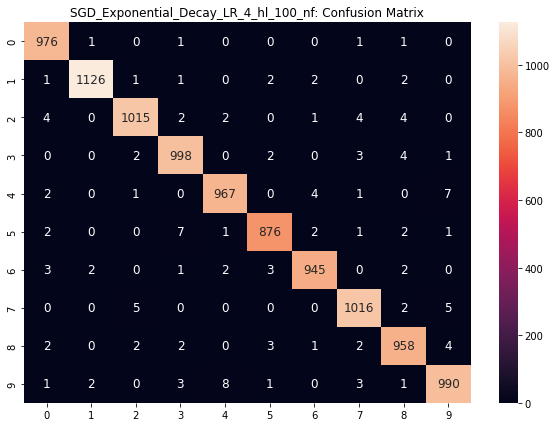

In [48]:
print("Best model: " + best_model.name)
plotModel(best_model, best_model.name, X_test, y_test)

El mejor modelo para el dataset MNIST, ha sido el modelo con 4 capas ocultas, 400, 300, 200 y 100 neuronas en ellas, SGD como optimizador y learning rate con decrecimiento exponencial.

Quizás la razón de que el decrecimiento exponencial haya triunfado, es que permite converger muy rápido dando un poco más de margen para seguir buscando el óptimo con un learning rate ya más pequeño. 

Si nos fijamos, SGD es el optimizador por defecto. Si bien el learning rate no ha sido el que se usa por defecto, éste también ha dado resultados excelentes. Ésto da que pensar, que quizás la selección de muchos hiperparámetros no son demasiado importantes, y la clave está en tener un modelo con un número suficiente de capas y neuronas, para que se pueda entrenar sin pérdidas de información.

Con esto no quiero decir que siempre haya que dejar estos valores por defecto: Si el optimizador por defecto fuera RMS-prop, y el learning rate por defecto fuera un scheduler cíclico, por ejemplo, nuestros resultados hubieran sido pésimos.

Dado que ya hemos acabado el trabajo, para añadir información interesante, vamos a volver a entrenar el modelo, esta vez usando Tensorboard con checkpoints, para visualizar el entrenamiento y estadísticas de una forma más interactiva.

### Entrenamiento usando Tensorboard

In [52]:
%load_ext tensorboard
import datetime

!rm -rf ./logs/
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%dd%mm%yyyy-%H%M%S")


The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [53]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("mnist.h5", save_best_only=True)
tensorboard_cb = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
model, history = neuralNetwork("BestModel", X_train, y_train, X_valid, y_valid, 
                               [28,28], 10, 4, [400,300,200,100], epochs = 20, hidden_function = "relu", 
                               output_function = "softmax", optimizer = tf.keras.optimizers.SGD(learning_rate = exponential_LR_fn), 
                               learning_rate = None, 
                               callbacks =[checkpoint_cb, early_stopping_cb, tensorboard_cb])


Epoch 1/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.2787 - accuracy: 0.9132 - val_loss: 0.1207 - val_accuracy: 0.9675
Epoch 2/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.1080 - accuracy: 0.9668 - val_loss: 0.0981 - val_accuracy: 0.9712
Epoch 3/20
1750/1750 [==============================] - 7s 4ms/step - loss: 0.0736 - accuracy: 0.9772 - val_loss: 0.0849 - val_accuracy: 0.9780
Epoch 4/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0520 - accuracy: 0.9839 - val_loss: 0.0834 - val_accuracy: 0.9793
Epoch 5/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0429 - accuracy: 0.9862 - val_loss: 0.0675 - val_accuracy: 0.9818
Epoch 6/20
1750/1750 [==============================] - 8s 4ms/step - loss: 0.0321 - accuracy: 0.9900 - val_loss: 0.0604 - val_accuracy: 0.9835
Epoch 7/20
1750/1750 [==============================] - 8s 5ms/step - loss: 0.0234 - accuracy: 0.9924 - val_loss: 0.0869 - val_accuracy:

In [54]:
%tensorboard --logdir logs/fit --host=0.0.0.0

Reusing TensorBoard on port 6006 (pid 19608), started 0:03:43 ago. (Use '!kill 19608' to kill it.)

# Bibliografía

   * Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow, 2nd edition
   * Optimal Learning Rate (Constant): https://towardsdatascience.com/estimating-optimal-learning-rate-for-a-deep-neural-network-ce32f2556ce0
   * LRFind class: https://sachinruk.github.io/blog/tensorflow/learning%20rate/2021/02/15/Tensorflow-Learning-Rate-Finder.html
   * LR Schedulers: 
       * https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/schedules
       * https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/
       * https://www.machinecurve.com/index.php/2019/11/11/problems-with-fixed-and-decaying-learning-rates/#what-is-learning-rate-decay
       * https://towardsdatascience.com/learning-rate-schedules-and-adaptive-learning-rate-methods-for-deep-learning-2c8f433990d1
   * CyclicalLearningRate: https://towardsdatascience.com/super-convergence-with-cyclical-learning-rates-in-tensorflow-c1932b858252
   * Optimizers: 
       * https://keras.io/api/optimizers/
       * https://www.kdnuggets.com/2020/12/optimization-algorithms-neural-networks.html
       * https://medium.com/mlearning-ai/optimizers-in-deep-learning-7bf81fed78a0
   * TensorBoard: https://www.tensorflow.org/tensorboard/get_started#:~:text=TensorBoard%20is%20a%20tool%20for,dimensional%20space%2C%20and%20much%20more.